<a href="https://colab.research.google.com/github/k73kahori/kaggle-notebook/blob/main/MoA_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mechanisms of Action (MoA) Prediction**  
引用：https://www.kaggle.com/competitions/lish-moa 

## 目次  
- 概要  
- ライブラリのインポート  
- データの読み込み  
- データの確認  
- データの前処理  
- ベースラインモデル  
- モデルの構築  
- テストデータによる汎化性能評価  
- まとめ

## 【概要】  
1. 課題  
今日の医薬品の開発は、疾患の分子生物学的メカニズムに基づいて行われている。  
すなわち、疾患に関連するタンパク質の標的を見出し、その標的タンパク質を調節する化合物を開発する。  
この候補化合物の探索過程では膨大な実験回数を要し、多くの期間と費用がかかる。これをどのように短縮・削減するかが、医薬品開発における課題の１つとなっている。  

2. 目的  
本ノートブックでは、ある化合物の細胞応答性のデータ（遺伝子発現と細胞の生存率）から作用機序（標的タンパク質に対する活性：mechanizm-of-action(MoA)）を予測するモデルを構築する。  
1つの化合物は複数のMoAを持つため、本来、このモデルはマルチラベルの分類問題となる。  
本ノートブックでは簡略化のため、**1つのMoAに限定（シングルラベル）**し、各化合物がpositiveかnegativeかを予測する**二値分類問題に変更**して検討を行った。  
化合物のMoAの予測モデルは、創薬の効率化に繋がるとともに、化合物の毒性や副作用の予測としても貢献できると考えられる。  

2. Datasets  
課題及びデータセットは、kaggleのコンペティションに出典されていたものを利用した。  
学習用データは、次のデータセットからなる。  
- train_drug.csvには、化合物の一覧が示される（drug_id）。  
ここで、sig_idは、次のtrain_features.csvのsig_idとリンクしている。  
- train_features.csvには、各化合物の細胞応答性の結果が示されている。  
g-0～g-771は遺伝子発現の結果を表し、c-0～c-99は細胞生存率の結果を表す。  
- 上記の化合物は全てMoAが既知であり、train_targets_scored.csv及び train_targets_nonscored.csvにMoAアノテーションが示されている。（コンペで予測対象としているのはtrain_targets_scoredに記載のもののみ）  

　　以上の学習用のデータセットを用い、細胞応答性のデータから、ある１つのMoAを予測するモデルを構築する。  

---

In [ ]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 【ライブラリのインポート】

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Keras
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers

# データの分割
from sklearn.model_selection import train_test_split

# JupyterNotebook上でグラフを表示する設定
%matplotlib inline
# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

## 【データの読み込み】

In [ ]:
# データの読み込み
train_drug = pd.read_csv("/content/drive/MyDrive/TechAcademy/AIコース/12_original/lish-moa/train_drug.csv")
train_features = pd.read_csv("/content/drive/MyDrive/TechAcademy/AIコース/12_original/lish-moa/train_features.csv")
train_scored = pd.read_csv("/content/drive/MyDrive/TechAcademy/AIコース/12_original/lish-moa/train_targets_scored.csv")
train_nonscored = pd.read_csv("/content/drive/MyDrive/TechAcademy/AIコース/12_original/lish-moa/train_targets_nonscored.csv")
test_features = pd.read_csv("/content/drive/MyDrive/TechAcademy/AIコース/12_original/lish-moa/test_features.csv")

In [ ]:
# データサイズの確認
print("train_drug:", train_drug.shape)
print("train_features:", train_features.shape)
print("train_scored:", train_scored.shape)
print("train_nonscored:", train_nonscored.shape)
print("test_features:", test_features.shape)

train_drug: (23814, 2)
train_features: (23814, 876)
train_scored: (23814, 207)
train_nonscored: (23814, 403)
test_features: (3982, 876)


## 【データの確認】

#### １．化合物データ

In [ ]:
# 学習データで使われている化合物の一覧
print(train_drug.shape)
train_drug.head()

(23814, 2)


sig_id    drug_id
0  id_000644bb2  b68db1d53
1  id_000779bfc  df89a8e5a
2  id_000a6266a  18bb41b2c
3  id_0015fd391  8c7f86626
4  id_001626bd3  7cbed3131

train_drugのsig_idは、train_featuresのsig_idとリンクしている。  
23814個のsig_idが確認できた。

In [ ]:
# 重複の確認
train_drug.iloc[:, 1].value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
32dccc366       1
f19d8c43b       1
c0521523c       1
67c4672f3       1
dd4a96d16       1
Name: drug_id, Length: 3289, dtype: int64

多くの化合物で重複がみられ、実際に使われている化合物は3289種。  
この重複は何のためのものか、データの中身を見て確認を行った。

In [ ]:
# 最も重複が多かった化合物 cacb2b860 の sig_id を取得。 sig_id_cacb2b860とする
sig_id_cacb2b860 = train_drug.query("drug_id == 'cacb2b860'").iloc[:, 0]
# リスト型に変換
sig_id_cacb2b860.to_list()

In [ ]:
# train_featuresから sig_id が sig_id_cacb2b860 に含まれるものを抽出する。isin()の引数にはリストを指定 
temp2 = train_features[train_features["sig_id"].isin(sig_id_cacb2b860)]
temp2.head()

sig_id      cp_type  cp_time cp_dose     g-0     g-1     g-2  \
25  id_0054388ec  ctl_vehicle       48      D1 -0.6696 -0.2718 -1.2230   
38  id_0079af0fb  ctl_vehicle       24      D1 -0.1636 -1.8230 -0.5211   
40  id_007bfbb91  ctl_vehicle       24      D2 -1.3200 -1.7340 -0.0741   
47  id_008a986b7  ctl_vehicle       48      D2  0.4860  0.1430  0.5281   
63  id_009d8340f  ctl_vehicle       24      D2  0.4471 -0.0839 -0.3864   

       g-3     g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11  \
25 -0.6226 -0.7220  0.1588  0.7785  0.7062 -0.7951  1.3770  0.2856 -0.8331   
38  0.3054 -1.1280  0.6041  0.3856 -0.1670 -0.5400  0.2721 -0.2479  0.0761   
40  1.5440 -1.8290 -0.0951  0.3829 -1.8700 -0.0324  2.7670 -0.0438 -0.0147   
47 -0.0022 -0.2334 -0.6607  0.6459 -0.0109  1.0120 -0.0864 -0.3817 -1.0600   
63  0.3196  0.2584 -0.3156 -0.1187  1.1610  0.5838 -0.2996 -0.3995  1.0700   

      g-12    g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20  \
25  0.3879  1.3290 -0.4746  0.0857 -0.2745 -0.1093  0.2603  0.7386 -0.6665   
38 -0.4054  2.9760 -0.7679  0.6995  0.0752  0.5943  0.4266  0.0000  1.0410   
40  0.1276  0.2968 -0.0704 -0.3767  2.5790  0.4069 -0.3868 -0.2782  1.8180   
47  0.9435  0.6296  0.3864  0.1420  0.9834  0.4189  0.7980 -0.2132  0.7651   
63  0.2969 -0.2785  0.9678 -0.1409  1.0850 -0.0656 -0.6502  0.3527  0.1998   

      g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29  \
25 -1.6520 -0.9262  0.0000  1.6310 -0.2933  0.2043 -2.2070  0.1383 -0.4966   
38 -0.1131  0.6593 -0.6890  0.5115 -0.2512 -0.8775 -1.3810  0.1419 -0.0363   
40 -2.9390 -0.1150 -0.8009 -1.4440  0.5412 -0.0804 -0.4444  2.9230  2.8270   
47 -1.2410  0.0747 -1.5750  0.1535 -0.0840  0.6705 -0.7517 -0.2756 -1.0920   
63  0.0975  0.0563 -0.3578 -0.0657  0.5316  0.6573 -0.5355  1.2380 -0.4994   

      g-30    g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38  \
25  0.6922 -0.4077  0.2303 -0.0456 -0.7447 -0.7060 -0.8653  0.0799 -0.6794   
38  0.2559  2.5290  0.2853  1.4690 -0.3626  0.2441  0.8413 -0.5191 -0.5716   
40 -0.3437  1.6570 -1.9200  0.3442  1.7160 -0.9357  1.2090  1.7850 -0.3803   
47 -0.8683  0.3021 -0.3164 -0.2074  0.4587  0.7203  0.5410 -0.1994  0.2482   
63 -0.8140  0.2567 -0.8155  1.1180 -0.2501 -0.3929 -0.2749  0.7495 -0.4184   

      g-39    g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47  \
25 -0.7271  0.7484  0.9398 -0.4682  0.3504 -0.4692  0.0667 -0.3710 -0.2616   
38 -0.2520 -0.4196  0.3469  1.9670 -0.7887  0.2735 -0.8081  0.6869  0.8164   
40 -1.4340 -0.8526 -0.7389 -2.3190 -0.9897  0.3555 -0.0915  0.3750  0.1015   
47 -1.4810  1.2520  1.6810 -0.3504  0.2071  0.2895  0.3483  0.0000  0.7818   
63 -0.4230 -0.1649  0.6628 -0.3647  0.6266  0.3857 -2.0780  0.0193 -0.3683   

      g-48    g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56  \
25 -0.6701 -0.3026 -0.4718 -0.6218 -0.0520 -0.1917  0.8563  0.5154  0.1378   
38  0.7297 -0.0036  0.5785  1.5020 -0.4690 -0.1823 -0.8385 -0.0231  0.0704   
40 -0.8848  0.9212  1.6000  1.4470 -0.4157 -0.6188  1.3180 -2.6000  0.9874   
47  0.5715  0.6740  0.3666  1.0210 -0.3084 -1.0230  0.7749 -0.8025  1.4470   
63  1.1770 -0.5276 -0.1582  1.0050  0.1412 -1.1800  0.8378  0.2456  0.8080   

      g-57    g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65  \
25  5.3440  0.2912  0.2847  0.2353  0.6480 -0.5767  0.0529  0.5968 -0.7108   
38  2.5560  0.4944  1.2630  0.0906  0.5972 -0.8117  0.3533  0.4166 -0.2259   
40  0.6055  0.8556 -2.8370 -0.1380 -0.8382 -0.2124 -0.4721 -0.9528 -0.2922   
47 -0.0154 -0.0993 -1.2850 -0.7999  0.2767  5.9220  0.3725 -0.2468 -0.6830   
63  0.9730  0.2765 -0.1600 -0.5344  0.6899 -0.3982 -0.3364  0.9665 -0.4969   

      g-66    g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74  \
25 -0.3615  0.1894  0.2440 -0.3330  0.5965 -0.0625  0.4877 -0.3314  2.9420   
38  0.6006 -1.4210 -1.1800 -0.2795  0.7591 -0.2467  1.1470 -0.5610  0.6470   
40 -0.1970 -2.2140 -1.9290  0.6332 -0.7473  1.78

In [ ]:
temp2.iloc[:, 1].value_counts()

ctl_vehicle    1866
Name: cp_type, dtype: int64

drug_id cacb2b860 は全てvehicle(コントロール)群だった。

In [ ]:
# 化合物 87d714366 の sig_id を取得。 sig_id_87d714366とする
sig_id_87d714366 = train_drug.query("drug_id == '87d714366'").iloc[:, 0]
# リスト型に変換
sig_id_87d714366.to_list()
# train_featuresから sig_id が sig_id_87d714366 に含まれるもののみを抽出
temp2 = train_features[train_features["sig_id"].isin(sig_id_87d714366)]
temp2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2    g-3  \
16   id_002fb9c19  trt_cp       48      D1   8.738  0.1914  2.4380 -0.293   
76   id_00cf039a7  trt_cp       48      D2   4.546  0.4257  0.7670  2.195   
119  id_01534c4ee  trt_cp       72      D2  10.000 -1.2200  1.5150 -2.191   
209  id_0236e3425  trt_cp       72      D1   3.612 -1.7130  0.0313 -1.736   
218  id_024a52260  trt_cp       24      D2   2.119  0.1098  1.1040  5.062   

        g-4     g-5     g-6    g-7    g-8    g-9   g-10    g-11    g-12  \
16   3.2010  1.4910  5.3920 -1.042 -8.486 -2.579 -6.747  3.6150 -1.4510   
76   2.5960  0.3677 -0.3854 -1.159 -8.180 -2.131 -4.168  2.5630 -1.3410   
119  4.3530 -0.9594  2.5600 -3.312 -9.507 -3.393 -4.160 -2.9320  0.0000   
209  3.3550 -1.7040  2.6010 -1.453 -9.534 -2.873 -4.465 -0.4308 -1.7920   
218 -0.7427 -0.3564 -0.8253 -3.618 -1.127 -2.136 -3.371  5.4820  0.0537   

       g-13    g-14    g-15   g-16    g-17    g-18    g-19    g-20    g-21  \
16   0.6909 -0.7623 -2.9400 -9.285 -6.7110 -0.4195  1.1600 -1.3180  1.3660   
76   5.2610 -2.5680  1.0840 -3.835 -4.8440  0.8522  0.2435 -2.6090  0.3067   
119  2.2650 -6.2560  0.1147 -4.209 -3.5580  3.2920  0.1551 -3.7200  0.1069   
209  3.8900 -3.4910  0.6124 -3.504 -4.4450 -1.4690 -2.8590 -1.4090  0.1560   
218  8.0940 -1.3650 -1.4740 -4.195  0.0338 -0.2759  0.3821 -0.6859 -2.6870   

       g-22   g-23    g-24    g-25   g-26    g-27   g-28    g-29   g-30  \
16  -1.4020 -2.622  0.7204 -2.5930 -4.063 -0.8282 -3.500  0.9206 -5.145   
76   0.9733 -1.608 -2.9210 -1.9570 -2.644  2.4030 -3.036 -6.4520 -3.258   
119  1.3000  1.971 -9.9350 -1.8340 -1.072  0.2092 -1.989 -4.0390 -6.047   
209 -3.1610 -1.571  0.0587 -0.0839 -3.619 -0.2986 -2.164 -2.1390 -3.929   
218  0.1784 -1.071 -4.1710  1.5710 -1.949 -1.0180 -4.791 -5.3540 -5.922   

      g-31    g-32   g-33    g-34    g-35    g-36    g-37    g-38   g-39  \
16   9.804 -2.6840 -2.439 -0.1427  4.2830  0.8084  -7.365   7.331  5.145   
76   4.355 -0.7562  0.993 -0.2854  1.4000 -0.5551  -8.016   9.059  3.697   
119  8.404  3.1040 -3.339 -2.8780  0.6408  3.5500  -4.652  10.000  0.286   
209  7.451 -1.0450  4.226 -3.5800  2.5210  0.5612  -6.335   9.830  1.787   
218  2.569 -1.5100 -2.796  3.0740 -0.3863 -5.7270 -10.000   6.292  1.909   

       g-40   g-41    g-42    g-43    g-44    g-45   g-46    g-47    g-48  \
16  -10.000 -8.139 -5.5870  1.2180  1.9250 -1.5480  2.995 -3.8510 -1.2630   
76   -4.057 -5.472  0.3979 -1.1110 -1.6090 -0.6168  4.426  1.1430  2.9110   
119  -0.706 -6.179  2.7230 -2.3380 -2.1370 -4.1910  6.995 -0.0371 -0.3658   
209  -8.648 -5.325 -2.6190  2.6970  3.4400 -0.2395  2.520 -1.5130 -2.1600   
218   1.279 -2.939 -1.5980 -0.6036 -0.2758 -1.1870  4.197  3.3500  6.1800   

       g-49   g-50    g-51    g-52    g-53    g-54   g-55    g-56   g-57  \
16   1.4270 -5.994  5.8080 -0.0756  9.3600  6.2720 -6.572 -0.6402 -2.160   
76   1.2090 -5.620  3.3070 -2.1700  0.9108 -0.4439 -1.342 -0.0506 -1.724   
119  0.1392 -7.210  1.2510 -0.0682 -1.1730 -1.0250 -1.918 -2.6070 -6.188   
209  4.0820 -5.016  5.4680  0.2760  7.2970  8.9210 -5.591  0.8400 -1.233   
218  1.5340 -8.782  0.0478 -4.4980 -0.2723  9.8210 -3.101  0.4344  6.018   

        g-58    g-59   g-60    g-61    g-62    g-63    g-64   g-65   g-66  \
16   -0.9194 -0.1328  1.527 -1.8300  -9.254  -7.264 -1.9760  4.005 -3.615   
76   -7.2070 -3.2660  2.274 -0.3479  -9.995  -4.168 -1.0640  3.212  2.062   
119  -8.3020 -0.8647  1.467 -5.7470 -10.000  -5.316  0.9749  1.657  1.576   
209  -0.6758 -0.2199  2.022 -2.9420  -6.592  -6.085 -0.2143  4.055  1.218   
218 -10.0000 -4.6780 -3.261 -2.5070  -2.104 -10.000 -2.8880  2.643  3.195   

       g-67    g-68    g-69   g-70    g-71    g-72    g-73    g-74    g-75  \
16   -7.185 -0.3827  3.2060 -3.016  2.0870 -10.000  0.6609  10.000 -10.000   
76  -10.000  3.2050  1.2040 -1.578  0.6957  -3.857 -0.1853   1.384 -10.000   
119 -10.000  7.2510  1.3300 -4.912 -0.4323  -1.905  0.7813   5.358 -10.000   
209  -9.949  3.0490  0.47

drug_id 87d714366に対し、薬剤の処理時間(cp_time)、薬剤の濃度(cp_dose)を変えて、それぞれ別々のsig_idに割り当てられている。

#### ２．細胞応答性データ（説明変数）

In [ ]:
# 学習データ（説明変数）
print(train_features.shape)
train_features.head()

(23814, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

- **cp_type:** trt_cp（薬剤あり）、ctl_vehicle（薬剤なし（コントロール）  
- **cp_time:** 24, 48, 72 hours（薬剤の処理時間）  
- **cp_dose:** D1 or D2 （高濃度か低濃度か）  

g-, c-データは値の範囲が揃っているため、正規化の処理は必要はないと考えられる（要約統計量も確認する）。   
cp_type, cp_time, cp_doseはそれぞれカテゴリー変数化を行う必要がある。

#### ２．MoAアノテーション（目的変数）

In [ ]:
# 学習データのMoA（コンペで扱う全ての目的変数）
print(train_scored.shape)
train_scored.head()

(23814, 207)


sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   adrenergic_receptor_antagonist  akt_inhibitor  \
0                               0              0   
1                               0              0   
2                               0              0   
3                               0              0   
4                               0              0   

   aldehyde_dehydrogenase_inhibitor  alk_inhibitor  ampk_activator  analgesic  \
0                                 0              0               0          0   
1                                 0              0               0          0   
2                                 0              0               0          0   
3                                 0              0               0          0   
4                                 0              0               0          0   

   androgen_receptor_agonist  androgen_receptor_antagonist  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   anesthetic_-_local  angiogenesis_inhibitor  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   

   angiotensin_receptor_antagonist  anti-inflammatory  antiarrhythmic  \
0                                0                  0               0   
1                                0                  0               0   
2                                0                  0               0   
3                                0                  0               0   
4                                0                  0               0   

   antibiotic  anticonvulsant  antifungal  antihistamine  antimalarial  \
0           0               0           0              0             0   
1          

- 207種のMoAに対して各化合物がpositiveであれば1、negativeであれば0のラベルが付与されている。  
→マルチラベルの分類問題である。    
- **今回は、207種のなかから目的変数を１つに絞り、test化合物がpositiveになるかを予測する二値分類の問題に変更してモデルの構築を行った。**  
- **どのMoAを選択するかについては、最もpositiveデータの多いMoAを採用することとした。**

In [ ]:
# 【参考】学習データのMoA（目的変数の対象以外のもの）
print(train_nonscored.shape)
train_nonscored.head()

(23814, 403)


sig_id  abc_transporter_expression_enhancer  abl_inhibitor  \
0  id_000644bb2                                    0              0   
1  id_000779bfc                                    0              0   
2  id_000a6266a                                    0              0   
3  id_0015fd391                                    0              0   
4  id_001626bd3                                    0              0   

   ace_inhibitor  acetylcholine_release_enhancer  \
0              0                               0   
1              0                               0   
2              0                               0   
3              0                               0   
4              0                               0   

   adenosine_deaminase_inhibitor  adenosine_kinase_inhibitor  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   adenylyl_cyclase_inhibitor  age_inhibitor  alcohol_dehydrogenase_inhibitor  \
0                           0              0                                0   
1                           0              0                                0   
2                           0              0                                0   
3                           0              0                                0   
4                           0              0                                0   

   aldehyde_dehydrogenase_activator  aldose_reductase_inhibitor  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   

   alpha_mannosidase_inhibitor  ampk_inhibitor  \
0                            0               0   
1                            0               0   
2                            0               0   
3                            0               0   
4                            0               0   

   androgen_biosynthesis_inhibitor  angiotensin_receptor_agonist  antacid  \
0                                0                             0        0   
1                                0                             0        0   
2                                0                             0        0   
3                                0                             0        0   
4                                0                             0        0   

   anthelmintic  antihypertensive  antimetabolite  antipruritic  \
0             0                 0               0             0   
1             0                 0               0             0   
2             0                 0               0             0   
3             0                 0               0             0   
4             0                 0               0             0   

   antirheumatic_drug  antiseptic  antispasmodic  antithyroid_agent  \
0                   0           0              0                  0   
1                   0           0              0                  0   
2                   0           0              0                  0   
3                   0           0              0                  0   
4                   0           0              0                  0   

   antitussive  anxiolytic  ap_inhibitor  apolipoprotein_expression_enhancer  \
0            0           0             0                                   0   
1            0           0             0                                   0   
2            0           0             0                                   0   
3            0           0             0                                   0   


本解析では、train_nonscoredに記載のMoAは除外してモデルの検討を行うが、化合物が標的とするタンパク質は、train_scoredに含まれる207種類以外にも体内に無数に存在することから、実際に創薬開発で運用する汎用性の高いモデルを構築するためには、これらnonscoredに含まれるMoA等についても考慮すべきと考えられる。

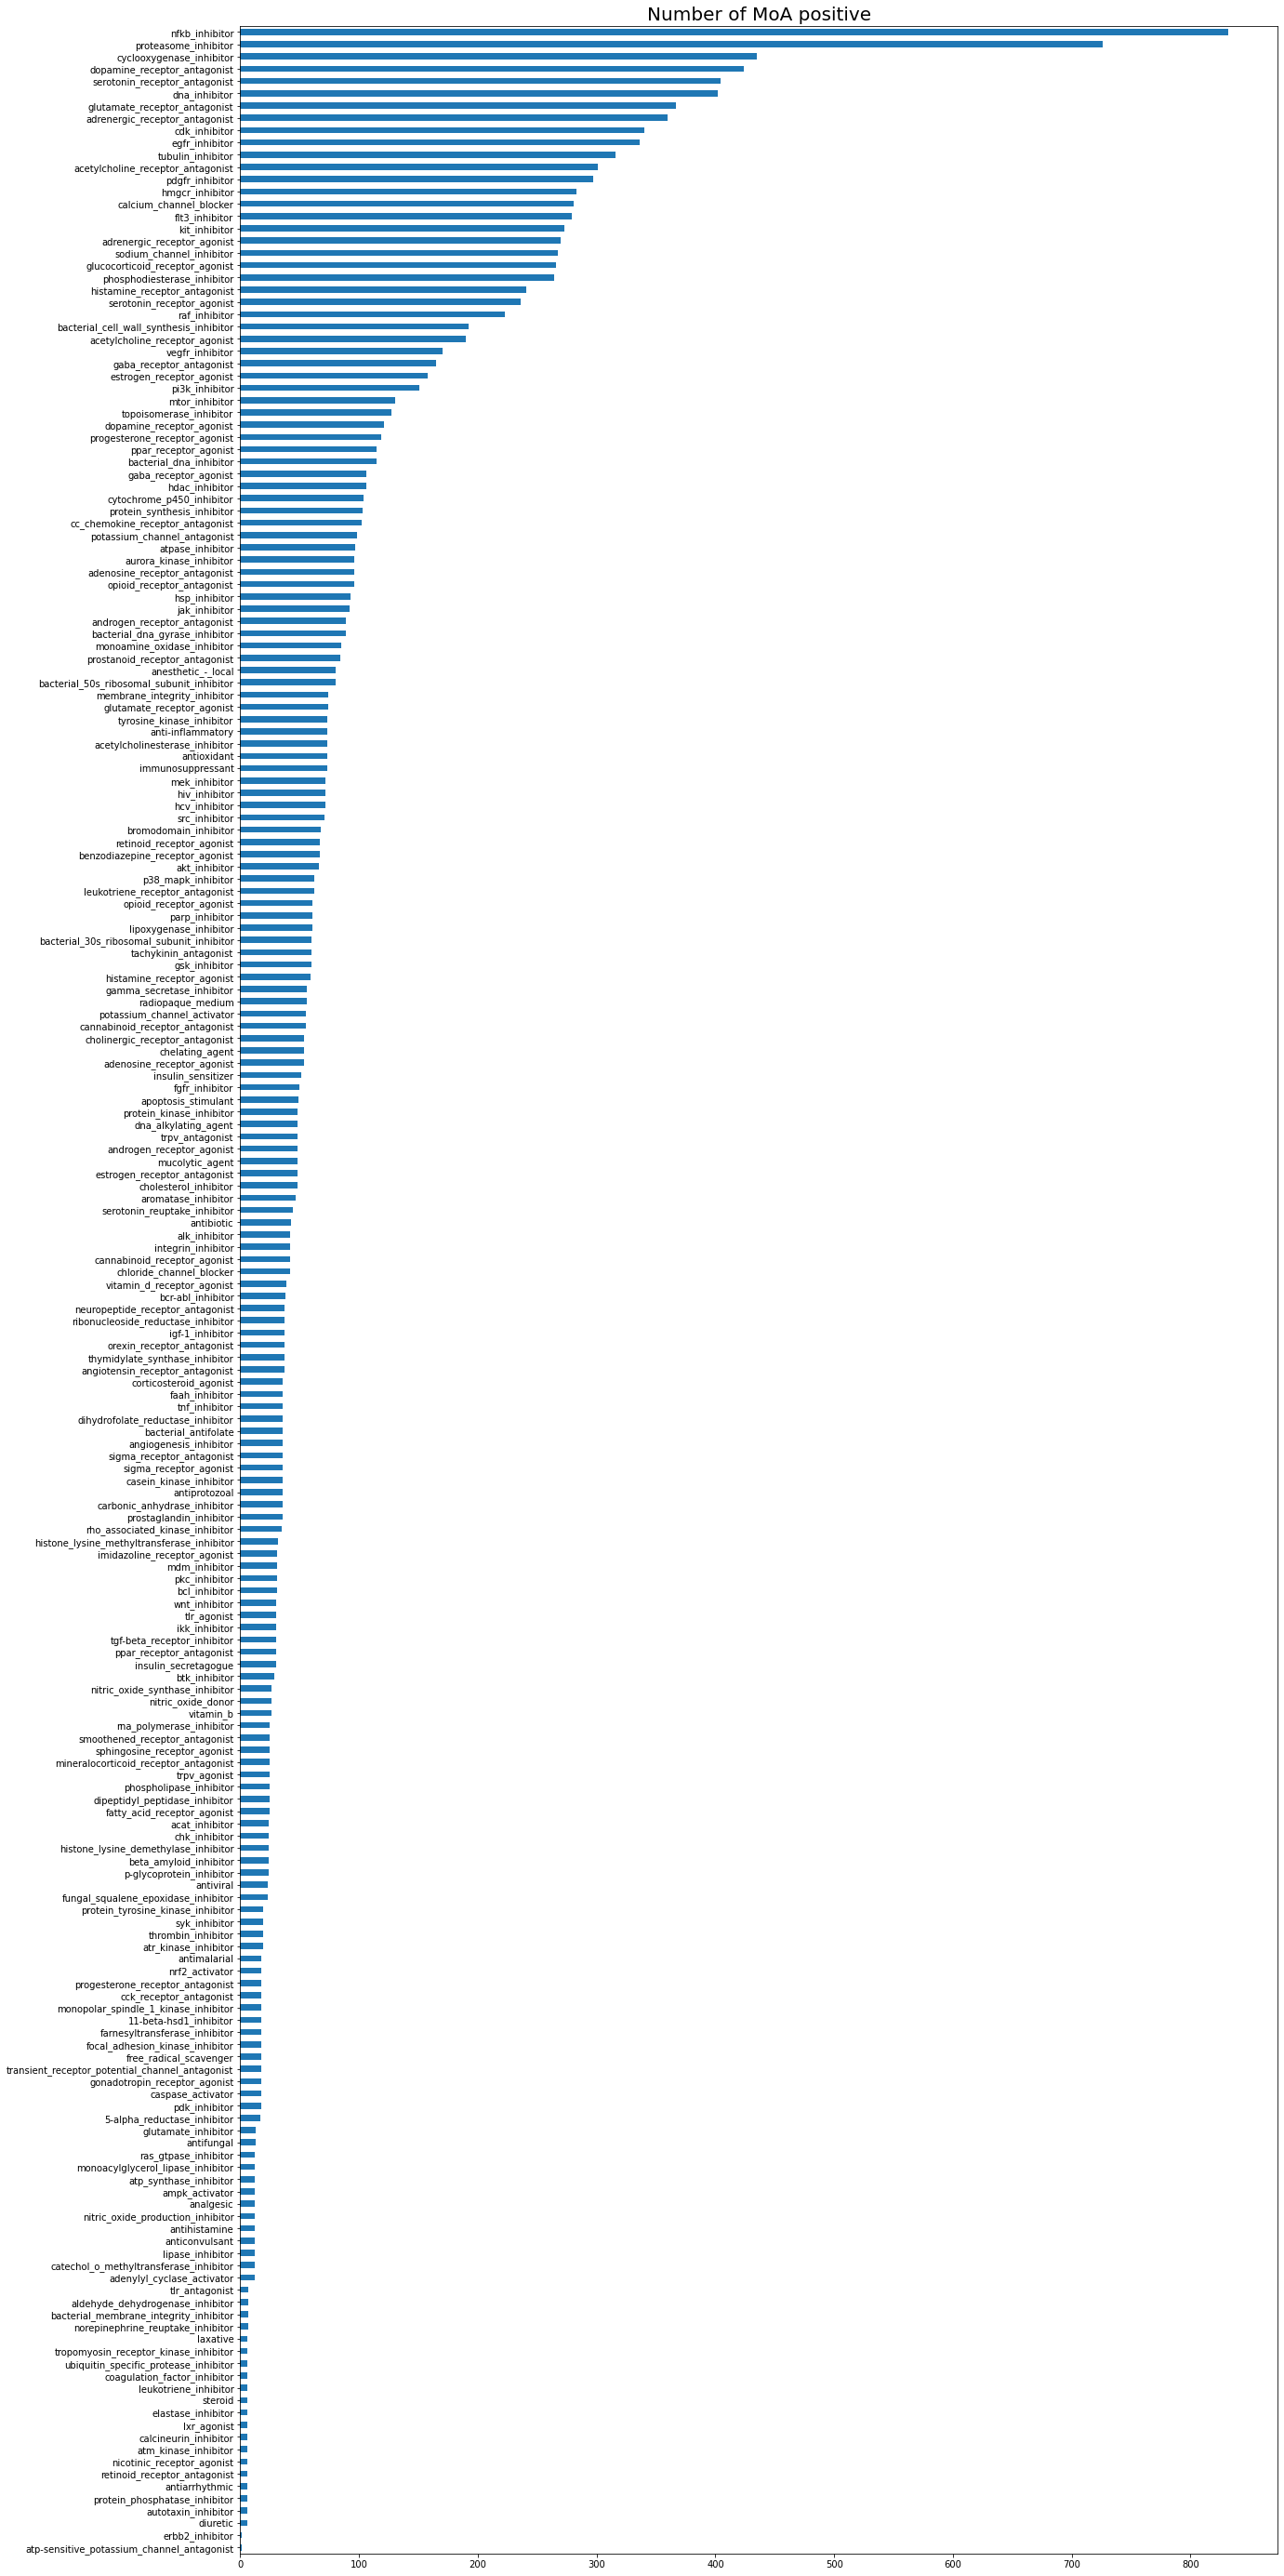

In [ ]:
# 207種のうち、最もpositiveデータの多いMoAを目的変数として採用する

# 各MoAについてpositiveデータの数を数える
count_positive = []
for i in range(1, 207):
    count = train_scored.iloc[:, i].value_counts()
    count_positive.append(count[1])
# リストをndarrayへ
nd_count_positive = np.array(count_positive)

# Series作成(列名は train_scored に含まれるMoA)
sr_count_positive = pd.Series(data = nd_count_positive, index = train_scored.iloc[:, 1:].columns.values)
# 要素で昇順にする
sr_count_positive_ = sr_count_positive.sort_values()

# 棒グラフで可視化
plt.figure(figsize=(20, 50)) 
sr_count_positive_.plot.barh()
plt.title("Number of MoA positive", fontsize=20)
plt.show()

今回は207個のMoAターゲットの中で、最もpositiveデータが多い **nfkb_inhibitor** に目的変数を絞り、以下二値分類を行うモデルを検討した。  

In [ ]:
# 目的変数（本検討用に変更）
train_scored2 = train_scored[["sig_id", "nfkb_inhibitor"]]

# positiveデータ（1）の個数
print(train_scored2.iloc[:, 1].value_counts())
train_scored2.head()

0    22982
1      832
Name: nfkb_inhibitor, dtype: int64


sig_id  nfkb_inhibitor
0  id_000644bb2               0
1  id_000779bfc               0
2  id_000a6266a               0
3  id_0015fd391               0
4  id_001626bd3               0

#### ３．欠損値の確認

In [ ]:
# 説明変数の欠損値の確認
print(train_features.isna().sum())

sig_id     0
cp_type    0
cp_time    0
cp_dose    0
g-0        0
          ..
c-95       0
c-96       0
c-97       0
c-98       0
c-99       0
Length: 876, dtype: int64


In [ ]:
train_features.isnull().values.sum() != 0

False

In [ ]:
# 説明変数のNullの確認
print(train_features.isnull().sum())

sig_id     0
cp_type    0
cp_time    0
cp_dose    0
g-0        0
          ..
c-95       0
c-96       0
c-97       0
c-98       0
c-99       0
Length: 876, dtype: int64


In [ ]:
# 辞書型に変換し、全行を表示
train_features.isnull().sum().to_dict()

{'sig_id': 0,
 'cp_type': 0,
 'cp_time': 0,
 'cp_dose': 0,
 'g-0': 0,
 'g-1': 0,
 'g-2': 0,
 'g-3': 0,
 'g-4': 0,
 'g-5': 0,
 'g-6': 0,
 'g-7': 0,
 'g-8': 0,
 'g-9': 0,
 'g-10': 0,
 'g-11': 0,
 'g-12': 0,
 'g-13': 0,
 'g-14': 0,
 'g-15': 0,
 'g-16': 0,
 'g-17': 0,
 'g-18': 0,
 'g-19': 0,
 'g-20': 0,
 'g-21': 0,
 'g-22': 0,
 'g-23': 0,
 'g-24': 0,
 'g-25': 0,
 'g-26': 0,
 'g-27': 0,
 'g-28': 0,
 'g-29': 0,
 'g-30': 0,
 'g-31': 0,
 'g-32': 0,
 'g-33': 0,
 'g-34': 0,
 'g-35': 0,
 'g-36': 0,
 'g-37': 0,
 'g-38': 0,
 'g-39': 0,
 'g-40': 0,
 'g-41': 0,
 'g-42': 0,
 'g-43': 0,
 'g-44': 0,
 'g-45': 0,
 'g-46': 0,
 'g-47': 0,
 'g-48': 0,
 'g-49': 0,
 'g-50': 0,
 'g-51': 0,
 'g-52': 0,
 'g-53': 0,
 'g-54': 0,
 'g-55': 0,
 'g-56': 0,
 'g-57': 0,
 'g-58': 0,
 'g-59': 0,
 'g-60': 0,
 'g-61': 0,
 'g-62': 0,
 'g-63': 0,
 'g-64': 0,
 'g-65': 0,
 'g-66': 0,
 'g-67': 0,
 'g-68': 0,
 'g-69': 0,
 'g-70': 0,
 'g-71': 0,
 'g-72': 0,
 'g-73': 0,
 'g-74': 0,
 'g-75': 0,
 'g-76': 0,
 'g-77': 0,
 'g-78': 0,
 'g

In [ ]:
train_features.isnull().values.sum() != 0

False

In [ ]:
# 目的変数のNullの確認
train_scored2.isnull().sum()

sig_id            0
nfkb_inhibitor    0
dtype: int64

In [ ]:
# 目的変数の欠損値の確認
train_scored2.isna().sum()

sig_id            0
nfkb_inhibitor    0
dtype: int64

Null及び欠損値は含まれていないことを確認した。

#### ４．要約統計量の確認

In [ ]:
train_features.describe()

cp_time           g-0           g-1           g-2           g-3  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      48.020156      0.248366     -0.095684      0.152253      0.081971   
std       19.402807      1.393399      0.812363      1.035731      0.950012   
min       24.000000     -5.513000     -5.737000     -9.104000     -5.998000   
25%       24.000000     -0.473075     -0.562200     -0.437750     -0.429575   
50%       48.000000     -0.008850     -0.046600      0.075200      0.008050   
75%       72.000000      0.525700      0.403075      0.663925      0.463400   
max       72.000000     10.000000      5.039000      8.257000     10.000000   

                g-4           g-5           g-6           g-7           g-8  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean       0.057347     -0.138836      0.035961     -0.202651     -0.190083   
std        1.032091      1.179388      0.882395      1.125494      1.749885   
min       -6.369000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.470925     -0.602225     -0.493900     -0.525175     -0.511675   
50%       -0.026900     -0.015650     -0.000650     -0.017900      0.010000   
75%        0.465375      0.510425      0.528725      0.411900      0.549225   
max       10.000000      7.282000      7.333000      5.473000      8.887000   

                g-9          g-10          g-11          g-12          g-13  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean       0.119905     -0.123321      0.182307      0.143203      0.209402   
std        1.087180      1.291501      1.253604      1.234590      1.273068   
min       -8.337000    -10.000000     -5.870000     -8.587000     -5.018000   
25%       -0.360200     -0.511475     -0.489675     -0.447500     -0.481200   
50%        0.160450      0.038550      0.013800      0.060250      0.009800   
75%        0.697775      0.525400      0.575275      0.604450      0.575825   
max        6.433000     10.000000     10.000000     10.000000     10.000000   

               g-14          g-15          g-16          g-17          g-18  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.173884     -0.024432      0.126823     -0.146663      0.087687   
std        1.247178      0.659839      1.418997      1.179688      0.743301   
min      -10.000000    -10.000000    -10.000000    -10.000000     -4.226000   
25%       -0.607975     -0.404150     -0.391950     -0.513775     -0.272200   
50%       -0.030100      0.000000      0.149400     -0.002200      0.000000   
75%        0.457975      0.382475      0.829500      0.494775      0.327800   
max       10.000000      4.134000      6.418000      4.750000      8.872000   

               g-19          g-20          g-21          g-22          g-23  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.082982     -0.111908     -0.087379      0.047548     -0.117474   
std        0.844796      1.219529      0.824401      0.924838      0.760159   
min      -10.000000    -10.000000     -5.700000    -10.000000    -10.000000   
25%       -0.488675     -0.524600     -0.538900     -0.440375     -0.508900   
50%       -0.027800     -0.002800     -0.069350     -0.011800      0.000000   
75%        0.400600      0.492400      0.414875      0.433400      0.329250   
max        4.081000      9.842000      5.248000      5.942000      5.201000   

               g-24          g-25          g-26          g-27          g-28  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.113212     -0.052746     -0.091055      0.112176     -0.046458   
std        1.203186      0.866977      1.103765      1.001687      1.027758   
min      -10.000000     -8.272000     -8.184000     -4.835000     -7.913000   
25%       -0.533900     -0.497700     -0.512875     -0.46

## 【データの前処理】

In [ ]:
# cp_type, cp_time, cp_doseをそれぞれカテゴリー変数化する。datasetとする。
dataset = pd.get_dummies(data=train_features, columns=["cp_type", "cp_time", "cp_dose"])
dataset.head()

sig_id     g-0     g-1     g-2     g-3     g-4     g-5     g-6  \
0  id_000644bb2  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220   
1  id_000779bfc  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341   
2  id_000a6266a  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715   
3  id_0015fd391 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095 -1.9590   
4  id_001626bd3 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244 -0.2800   

      g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14    g-15  \
0 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789 -0.6528   
1  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803  0.2250   
2  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057 -0.3278   
3  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690  0.8183   
4 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042  0.1970   

     g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23    g-24  \
0 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940  0.4393   
1  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372  0.3135   
2  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307  0.4901   
3 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004 -1.4670   
4  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057  1.3720   

     g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32    g-33  \
0  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916 -0.3010   
1 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959 -0.2483   
2  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290  0.1783   
3 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881 -2.7370  0.8745   
4  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389  0.6674 -0.0783   

     g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41    g-42  \
0 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566 -1.1980   
1  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958 -1.1730   
2  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561  0.0357   
3  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229 -0.0010  0.1353   
4  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302  0.1224  0.9584   

     g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50    g-51  \
0  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221 -0.4927   
1  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730 -0.5036   
2 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978 -0.2661   
3 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636 -2.8230 -0.6035   
4  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147 -0.0803 -0.3818   

     g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59    g-60  \
0  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588  0.6061   
1 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408 -0.5814   
2  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370  0.5553   
3 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899 -1.5240  0.3936   
4  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709  0.6745  0.7871   

     g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68    g-69  \
0 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551 -0.7395   
1  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054  0.1197   
2  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916  0.6809   
3  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186  1.5370  0.3868   
4  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255 -0.1556 -0.5436   

     g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77    g-78  \
0 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763 -0.8550   
1  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842  1.1870   
2  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.2306 -0.4130 -0.1406   
3 -0.4038

In [ ]:
# 列同士の相関を確認
df_corr = dataset.iloc[:, 1:873].corr()
df_corr.head()

g-0       g-1       g-2       g-3       g-4       g-5       g-6  \
g-0  1.000000  0.086032  0.176188  0.011266  0.403153 -0.165478  0.238348   
g-1  0.086032  1.000000 -0.054518 -0.027855  0.193647 -0.151590 -0.122541   
g-2  0.176188 -0.054518  1.000000  0.042633  0.013968  0.018516  0.015190   
g-3  0.011266 -0.027855  0.042633  1.000000 -0.033039  0.042231 -0.043177   
g-4  0.403153  0.193647  0.013968 -0.033039  1.000000 -0.057449  0.206405   

          g-7       g-8       g-9      g-10      g-11      g-12      g-13  \
g-0 -0.374451 -0.604212 -0.428779 -0.547606  0.219762 -0.199453  0.472223   
g-1  0.144537 -0.009973 -0.047558 -0.009051  0.161274  0.037178 -0.009256   
g-2 -0.144205 -0.128029 -0.081332 -0.105050  0.011198 -0.063501  0.082011   
g-3 -0.175692 -0.086167 -0.014052 -0.074101  0.181024  0.030539  0.192727   
g-4 -0.032748 -0.474828 -0.274167 -0.458021  0.116467 -0.207078  0.210440   

         g-14      g-15      g-16      g-17      g-18      g-19      g-20  \
g-0 -0.346179 -0.201323 -0.513026 -0.433536 -0.002073 -0.074622 -0.468599   
g-1  0.002632 -0.070193 -0.063414 -0.000944 -0.023748 -0.034714 -0.131031   
g-2 -0.082204 -0.059607 -0.137811 -0.085491  0.053335  0.028813 -0.061160   
g-3  0.128792 -0.045688  0.033974 -0.070920  0.237669  0.112392  0.027867   
g-4 -0.307280  0.019531 -0.275700 -0.422889 -0.012207 -0.088152 -0.311798   

         g-21      g-22      g-23      g-24      g-25      g-26      g-27  \
g-0  0.052445  0.022269 -0.076298 -0.337522 -0.235191 -0.422814  0.148432   
g-1  0.196596 -0.061441  0.090620 -0.004299 -0.032600 -0.019435  0.015661   
g-2 -0.129131 -0.007426 -0.034230 -0.128312 -0.067363 -0.126554  0.036984   
g-3 -0.167263  0.197013 -0.049480 -0.113336  0.175615  0.111355  0.007168   
g-4  0.286106 -0.055368 -0.113396 -0.120743 -0.233682 -0.340708  0.070292   

         g-28      g-29      g-30      g-31      g-32      g-33      g-34  \
g-0 -0.471092 -0.296871 -0.528327  0.558136 -0.133229 -0.155987 -0.120247   
g-1 -0.098907 -0.091071 -0.053331 -0.049514  0.187382 -0.091232  0.045417   
g-2 -0.129481 -0.017941 -0.152288  0.172191 -0.100086 -0.033010 -0.015481   
g-3 -0.022381 -0.128269 -0.042827  0.098416 -0.091962 -0.083806  0.184985   
g-4 -0.360274 -0.225461 -0.402256  0.324362  0.091731 -0.052787 -0.073490   

         g-35      g-36      g-37      g-38      g-39      g-40      g-41  \
g-0  0.327593 -0.147800 -0.591868  0.602623  0.450769 -0.432426 -0.499815   
g-1  0.044373 -0.077671 -0.005265 -0.042213  0.050546  0.000655 -0.110238   
g-2  0.001098 -0.020374 -0.157977  0.169464  0.144449 -0.080201 -0.109646   
g-3 -0.070933 -0.317859 -0.228039  0.084346  0.054827  0.114685 -0.047136   
g-4  0.195062 -0.124394 -0.277002  0.285256  0.300517 -0.309149 -0.373390   

         g-42      g-43      g-44      g-45      g-46      g-47      g-48  \
g-0 -0.203828  0.021582 -0.023423 -0.119687  0.530238  0.039827  0.238235   
g-1  0.133896  0.161186 -0.092498  0.031993  0.097674 -0.012420  0.029064   
g-2 -0.121433 -0.086435  0.021241 -0.036105  0.142712 -0.009575  0.039119   
g-3 -0.010941 -0.168398 -0.001770  0.065444  0.082046  0.297146  0.173796   
g-4  0.071462  0.185361 -0.105936 -0.033695  0.355833 -0.060724  0.006138   

         g-49      g-50      g-51      g-52      g-53      g-54      g-55  \
g-0  0.310583 -0.560201  0.291476 -0.293906  0.263799  0.318724 -0.456709   
g-1 -0.106349 -0.028870 -0.057648  0.037969 -0.059497 -0.019873  0.114727   
g-2  0.052003 -0.140002  0.047647 -0.058874  0.054844  0.085142 -0.159016   
g-3  0.072970 -0.233491  0.125193 -0.163648  0.012809  0.068682 -0.126877   
g-4  0.114748 -0.315675  0.165373 -0.069761  0.185821  0.116731 -0.146464   

         g-56      g-57      g-58      g-59      g-60      g-61      g-62  \
g-0 -0.130850 -0.245901 -0.481191 -0.200365  0.095231 -0.385378 -0.606430   
g-1 -0.127237 -0.056013 -0.043314  0.184889 -0.047734  0.098201  0.043737   
g-2 -0.035817 -0.042007 -0.128388 -0.124065  0.090874 -0.138144 -0.137042  

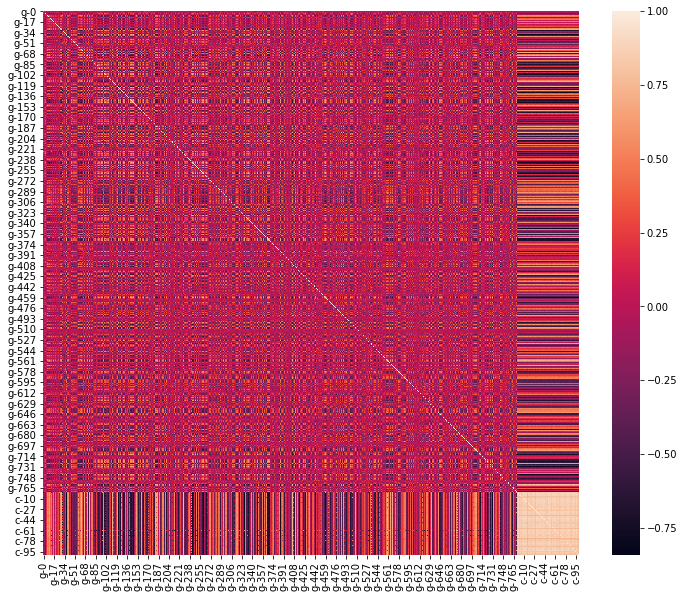

In [ ]:
# 相関係数をヒートマップで可視化
plt.figure(figsize=(12, 10)) 
sns.heatmap(df_corr)

- g-とc-の間では相関の高い組み合わせが多くみられる。    
- c-同士のデータは全体的に相関が高い。  
→ 説明変数が多いため、L1正則化が有効と予想した。また、相関関係があるものも多く認められることから、主成分分析も有効である可能性がある。

In [ ]:
# 説明変数(X)：g-0～g-771、c-0～c-99、cp_type、cp_time、cp-dose
# 目的変数(Y)："nfkb_inhibitor"
X = np.array(dataset.iloc[:, 1:])
Y = np.array(train_scored2["nfkb_inhibitor"])

In [ ]:
# 形状を確認
print("Y=", Y.shape, ", X=", X.shape)

Y= (23814,) , X= (23814, 879)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (11668,) , X_train= (11668, 879)
Y_valid= (5001,) , X_valid= (5001, 879)
Y_test= (7145,) , X_test= (7145, 879)


## 【Baseline model】

In [ ]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(1024, activation="relu", input_shape=(879,)))
# 隠れ層
model.add(Dense(32, activation="relu"))
# 出力層
model.add(Dense(1, activation="sigmoid"))

# モデルの構築
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              901120    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 933,953
Trainable params: 933,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1)], validation_data=(X_valid, Y_valid))

2022-10-26 14:36:41.868184: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 41024688 exceeds 10% of free system memory.


Epoch 1/1000
365/365 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9861

2022-10-26 14:36:52.901132: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 8s 23ms/step - loss: 0.1096 - accuracy: 0.9861 - val_loss: 0.0545 - val_accuracy: 0.9894
Epoch 2/1000
365/365 [==============================] - 7s 18ms/step - loss: 0.0561 - accuracy: 0.9915 - val_loss: 0.0765 - val_accuracy: 0.9928
Epoch 3/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.0537 - accuracy: 0.9923 - val_loss: 0.1129 - val_accuracy: 0.9914
Epoch 4/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.0284 - accuracy: 0.9942 - val_loss: 0.1507 - val_accuracy: 0.9920
Epoch 5/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.0189 - accuracy: 0.9973 - val_loss: 0.1934 - val_accuracy: 0.9924
Epoch 6/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.0267 - accuracy: 0.9976 - val_loss: 0.2665 - val_accuracy: 0.9916
Epoch 7/1000
365/365 [==============================] - 3s 10ms/step - loss: 0.0214 - accuracy: 0.9979 - val_loss: 0.2497 - val_accuracy: 0.9896
E

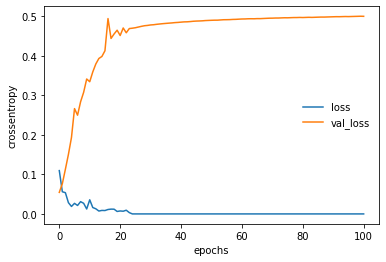

In [ ]:
# グラフの表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

#### ≪結果≫    
過学習が起きている  
→説明変数が多く、相関のあるものも多くあるためL1正則化の導入を試みる

## 【モデルの検討】


#### １．L1正則化

In [ ]:
# モデルの初期化
model2 = keras.Sequential()

# 入力層
model2.add(Dense(1024, activation="relu", input_shape=(879,)))
# 隠れ層
model2.add(Dense(32, activation="relu", activity_regularizer=regularizers.l1(0.01)))
# 出力層
model2.add(Dense(1, activation="sigmoid"))

# モデルの構築
model2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

2022-10-26 15:28:31.506983: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-26 15:28:31.511722: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-26 15:28:31.516852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-239): /proc/driver/nvidia/version does not exist
2022-10-26 15:28:31.567095: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-10-26 15:28:32.434904: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2400020000 Hz
2022-10-26 15:28:32.444089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f277c0013e0 initialized for platform Host (this does not guarante

In [ ]:
# モデルの構造を表示
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              901120    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 933,953
Trainable params: 933,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model2.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1)], validation_data=(X_valid, Y_valid))

2022-10-26 15:29:26.395668: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 41024688 exceeds 10% of free system memory.


Epoch 1/1000
365/365 [==============================] - 5s 14ms/step - loss: 0.1759 - accuracy: 0.9726 - val_loss: 0.1389 - val_accuracy: 0.9670
Epoch 2/1000
361/365 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9712

2022-10-26 15:29:43.035681: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 7s 18ms/step - loss: 0.1200 - accuracy: 0.9712 - val_loss: 0.1178 - val_accuracy: 0.9670
Epoch 3/1000
363/365 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9668

2022-10-26 15:29:48.969895: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 5s 13ms/step - loss: 0.1050 - accuracy: 0.9667 - val_loss: 0.1029 - val_accuracy: 0.9670
Epoch 4/1000
365/365 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9749

2022-10-26 15:29:53.654966: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 3s 9ms/step - loss: 0.0849 - accuracy: 0.9749 - val_loss: 0.0973 - val_accuracy: 0.9778
Epoch 5/1000
364/365 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9776

2022-10-26 15:29:57.409971: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 10ms/step - loss: 0.0790 - accuracy: 0.9776 - val_loss: 0.0867 - val_accuracy: 0.9824
Epoch 6/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.0677 - accuracy: 0.9781 - val_loss: 0.0803 - val_accuracy: 0.9820
Epoch 7/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.0656 - accuracy: 0.9691 - val_loss: 0.0847 - val_accuracy: 0.9670
Epoch 8/1000
365/365 [==============================] - 3s 10ms/step - loss: 0.0760 - accuracy: 0.9847 - val_loss: 0.0840 - val_accuracy: 0.9876
Epoch 9/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.0630 - accuracy: 0.9879 - val_loss: 0.0831 - val_accuracy: 0.9858
Epoch 10/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.0632 - accuracy: 0.9887 - val_loss: 0.0886 - val_accuracy: 0.9800
Epoch 11/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.0698 - accuracy: 0.9879 - val_loss: 0.0900 - val_accuracy: 0.977

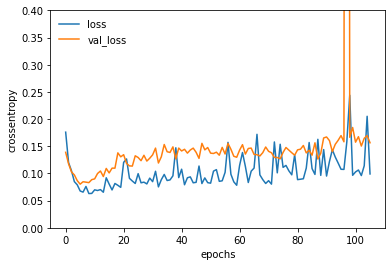

In [ ]:
# グラフの表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.ylim(0, 0.4)
plt.show()

#### ≪結果≫    
過学習は改善されていない。trainデータのlossがガタガタになった。  
L1正則化を入れる引数が2種類あり、上記ではactivity_regularizerを試したが、kernel_regularizerも試してみる。

#### ２．L1正則化の引数変更

In [ ]:
# モデルの初期化
model2_2 = keras.Sequential()

# 入力層
model2_2.add(Dense(1024, activation="relu", input_shape=(879,)))
# 隠れ層
model2_2.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l1(0.01)))
# 出力層
model2_2.add(Dense(1, activation="sigmoid"))

# モデルの構築
model2_2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

2022-10-27 07:39:44.108661: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 07:39:44.113301: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 07:39:44.121379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-239): /proc/driver/nvidia/version does not exist
2022-10-27 07:39:44.180606: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-10-27 07:39:45.076663: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2400010000 Hz
2022-10-27 07:39:45.085160: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f79140013e0 initialized for platform Host (this does not guarante

In [ ]:
# モデルの構造を表示
model2_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              901120    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 933,953
Trainable params: 933,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model2_2.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1)], validation_data=(X_valid, Y_valid))

2022-10-27 07:40:25.616775: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 41024688 exceeds 10% of free system memory.


Epoch 1/1000
360/365 [============================>.] - ETA: 0s - loss: 1.0938 - accuracy: 0.9863

2022-10-27 07:40:36.697839: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 5s 14ms/step - loss: 1.0833 - accuracy: 0.9864 - val_loss: 0.2464 - val_accuracy: 0.9876
Epoch 2/1000
362/365 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9928

2022-10-27 07:40:40.599160: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 10ms/step - loss: 0.2292 - accuracy: 0.9928 - val_loss: 0.2685 - val_accuracy: 0.9864
Epoch 3/1000
360/365 [============================>.] - ETA: 0s - loss: 0.2174 - accuracy: 0.9935

2022-10-27 07:40:44.156198: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 10ms/step - loss: 0.2175 - accuracy: 0.9935 - val_loss: 0.3075 - val_accuracy: 0.9916
Epoch 4/1000
362/365 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9941

2022-10-27 07:40:47.649765: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 3s 10ms/step - loss: 0.2121 - accuracy: 0.9942 - val_loss: 0.2133 - val_accuracy: 0.9932
Epoch 5/1000
365/365 [==============================] - 3s 10ms/step - loss: 0.2078 - accuracy: 0.9941 - val_loss: 0.2116 - val_accuracy: 0.9934
Epoch 6/1000
365/365 [==============================] - 4s 11ms/step - loss: 0.2037 - accuracy: 0.9943 - val_loss: 0.2105 - val_accuracy: 0.9934
Epoch 7/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.2020 - accuracy: 0.9944 - val_loss: 0.2085 - val_accuracy: 0.9938
Epoch 8/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.2011 - accuracy: 0.9947 - val_loss: 0.2076 - val_accuracy: 0.9938
Epoch 9/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.1984 - accuracy: 0.9946 - val_loss: 0.2078 - val_accuracy: 0.9936
Epoch 10/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.1959 - accuracy: 0.9953 - val_loss: 0.2087 - val_accuracy: 0.9934

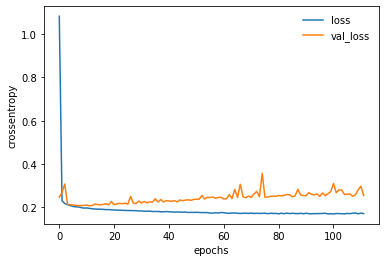

In [ ]:
# グラフの表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

#### ≪結果≫  
L1正則化項をactivity_regularizer→kernel_regularizerに変更しただけだが、グラフがきれいになった。  
train_lossも右肩下がりに減少し、学習が進んでいることが確認できた。  
しかしまだ過学習は改善しきれていない。  
→Dropout層を導入してみる。

#### ３．Dropout層の導入

In [ ]:
# モデルの初期化
model3 = keras.Sequential()

# 入力層
model3.add(Dense(1024, activation="relu", input_shape=(879,)))
model3.add(Dropout(0.25))
# 隠れ層
model3.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l1(0.01)))
model3.add(Dropout(0.5))
# 出力層
model3.add(Dense(1, activation="sigmoid"))

# モデルの構築
model3.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

2022-10-27 09:49:51.657192: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 09:49:51.659893: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 09:49:51.670430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-239): /proc/driver/nvidia/version does not exist
2022-10-27 09:49:51.695693: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-10-27 09:49:52.488667: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2400010000 Hz
2022-10-27 09:49:52.503811: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f21e00013e0 initialized for platform Host (this does not guarante

In [ ]:
# モデルの構造を表示
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              901120    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 933,953
Trainable params: 933,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model3.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1)], validation_data=(X_valid, Y_valid))

2022-10-27 09:50:31.684414: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 41024688 exceeds 10% of free system memory.


Epoch 1/1000
365/365 [==============================] - ETA: 0s - loss: 1.3925 - accuracy: 0.9786

2022-10-27 09:50:40.523394: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 6s 16ms/step - loss: 1.3925 - accuracy: 0.9786 - val_loss: 0.2447 - val_accuracy: 0.9914
Epoch 2/1000
361/365 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.9868

2022-10-27 09:50:44.308539: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 10ms/step - loss: 0.2966 - accuracy: 0.9868 - val_loss: 0.2778 - val_accuracy: 0.9936
Epoch 3/1000
364/365 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.9874

2022-10-27 09:50:48.185616: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 11ms/step - loss: 0.2829 - accuracy: 0.9873 - val_loss: 0.2480 - val_accuracy: 0.9928
Epoch 4/1000
361/365 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.9884

2022-10-27 09:50:52.599301: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17583516 exceeds 10% of free system memory.


365/365 [==============================] - 4s 12ms/step - loss: 0.2898 - accuracy: 0.9885 - val_loss: 0.2825 - val_accuracy: 0.9924
Epoch 5/1000
365/365 [==============================] - 3s 9ms/step - loss: 0.2742 - accuracy: 0.9904 - val_loss: 0.2400 - val_accuracy: 0.9930
Epoch 6/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.2764 - accuracy: 0.9903 - val_loss: 0.2271 - val_accuracy: 0.9926
Epoch 7/1000
365/365 [==============================] - 4s 11ms/step - loss: 0.2712 - accuracy: 0.9919 - val_loss: 0.2310 - val_accuracy: 0.9940
Epoch 8/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.2875 - accuracy: 0.9898 - val_loss: 0.3372 - val_accuracy: 0.9932
Epoch 9/1000
365/365 [==============================] - 4s 10ms/step - loss: 0.2815 - accuracy: 0.9908 - val_loss: 0.2390 - val_accuracy: 0.9894
Epoch 10/1000
365/365 [==============================] - 4s 12ms/step - loss: 0.2728 - accuracy: 0.9907 - val_loss: 0.2177 - val_accuracy: 0.991

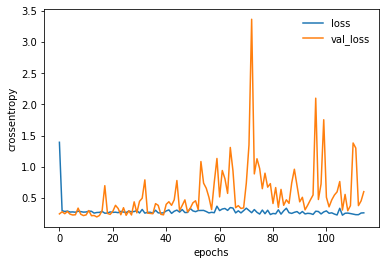

In [ ]:
# グラフの表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

#### ≪結果≫  
val_lossがあばれている。  
Dropout層を入れたことにより、validationデータへの当てはまりが悪くなったか。  
train_lossが右肩下がりに下がっておらず、学習も不十分である可能性がある。    
→Dropout層は削除する。過学習に対する対応としては、モデルの複雑化を検討する（inputを減らして層を増やす）。

#### ４．データの前処理の再検討（説明変数の削減）

In [ ]:
# inputを減らすために、目的変数（nfkb_inhibitor）に相関のある説明変数を抽出する
# datasetに nfkb_inhibitor のデータを入れる
dataset.insert(1, "nfkb_inhibitor", train_scored2["nfkb_inhibitor"])
print(dataset.shape)
dataset.head()

(23814, 881)


sig_id  nfkb_inhibitor     g-0     g-1     g-2     g-3     g-4  \
0  id_000644bb2               0  1.0620  0.5577 -0.2479 -0.6208 -0.1944   
1  id_000779bfc               0  0.0743  0.4087  0.2991  0.0604  1.0190   
2  id_000a6266a               0  0.6280  0.5817  1.5540 -0.0764 -0.0323   
3  id_0015fd391               0 -0.5138 -0.2491 -0.2656  0.5288  4.0620   
4  id_001626bd3               0 -0.3254 -0.4009  0.9700  0.6919  1.4180   

      g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13  \
0 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015   
1  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590   
2  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300   
3 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844   
4 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750   

     g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22  \
0  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880   
1  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657   
2  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320   
3 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191   
4  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649   

     g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31  \
0  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584   
1 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627   
2  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069   
3 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881   
4  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389   

     g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40  \
0 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347   
1  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194   
2  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477   
3 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229   
4  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302   

     g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49  \
0 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233   
1 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900   
2 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552   
3 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636   
4  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147   

     g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58  \
0 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790   
1  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249   
2 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757   
3 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899   
4 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709   

     g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67  \
0  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195   
1 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954   
2 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939   
3 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186   
4  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255   

     g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76  \
0  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330   
1 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933   
2  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.2306   
3  1.5370

In [ ]:
# それぞれの説明変数（g-0～g-771、c-0～c-99）と目的変数との相関関係を把握する
df_corr2 = dataset.iloc[:, 1:874].corr()
df_corr2 = df_corr2.iloc[0, 1:]
df_corr2.head()

g-0    0.569808
g-1    0.075256
g-2    0.158679
g-3    0.144750
g-4    0.361672
Name: nfkb_inhibitor, dtype: float64

In [ ]:
# 相関係数の大きい順にソート
df_corr2_ = df_corr2.sort_values()
df_corr2_

c-78    -0.759826
c-32    -0.745395
c-53    -0.741434
c-31    -0.741166
c-16    -0.730591
           ...   
g-368    0.657404
g-248    0.666832
g-123    0.669726
g-460    0.670880
g-349    0.730145
Name: nfkb_inhibitor, Length: 872, dtype: float64

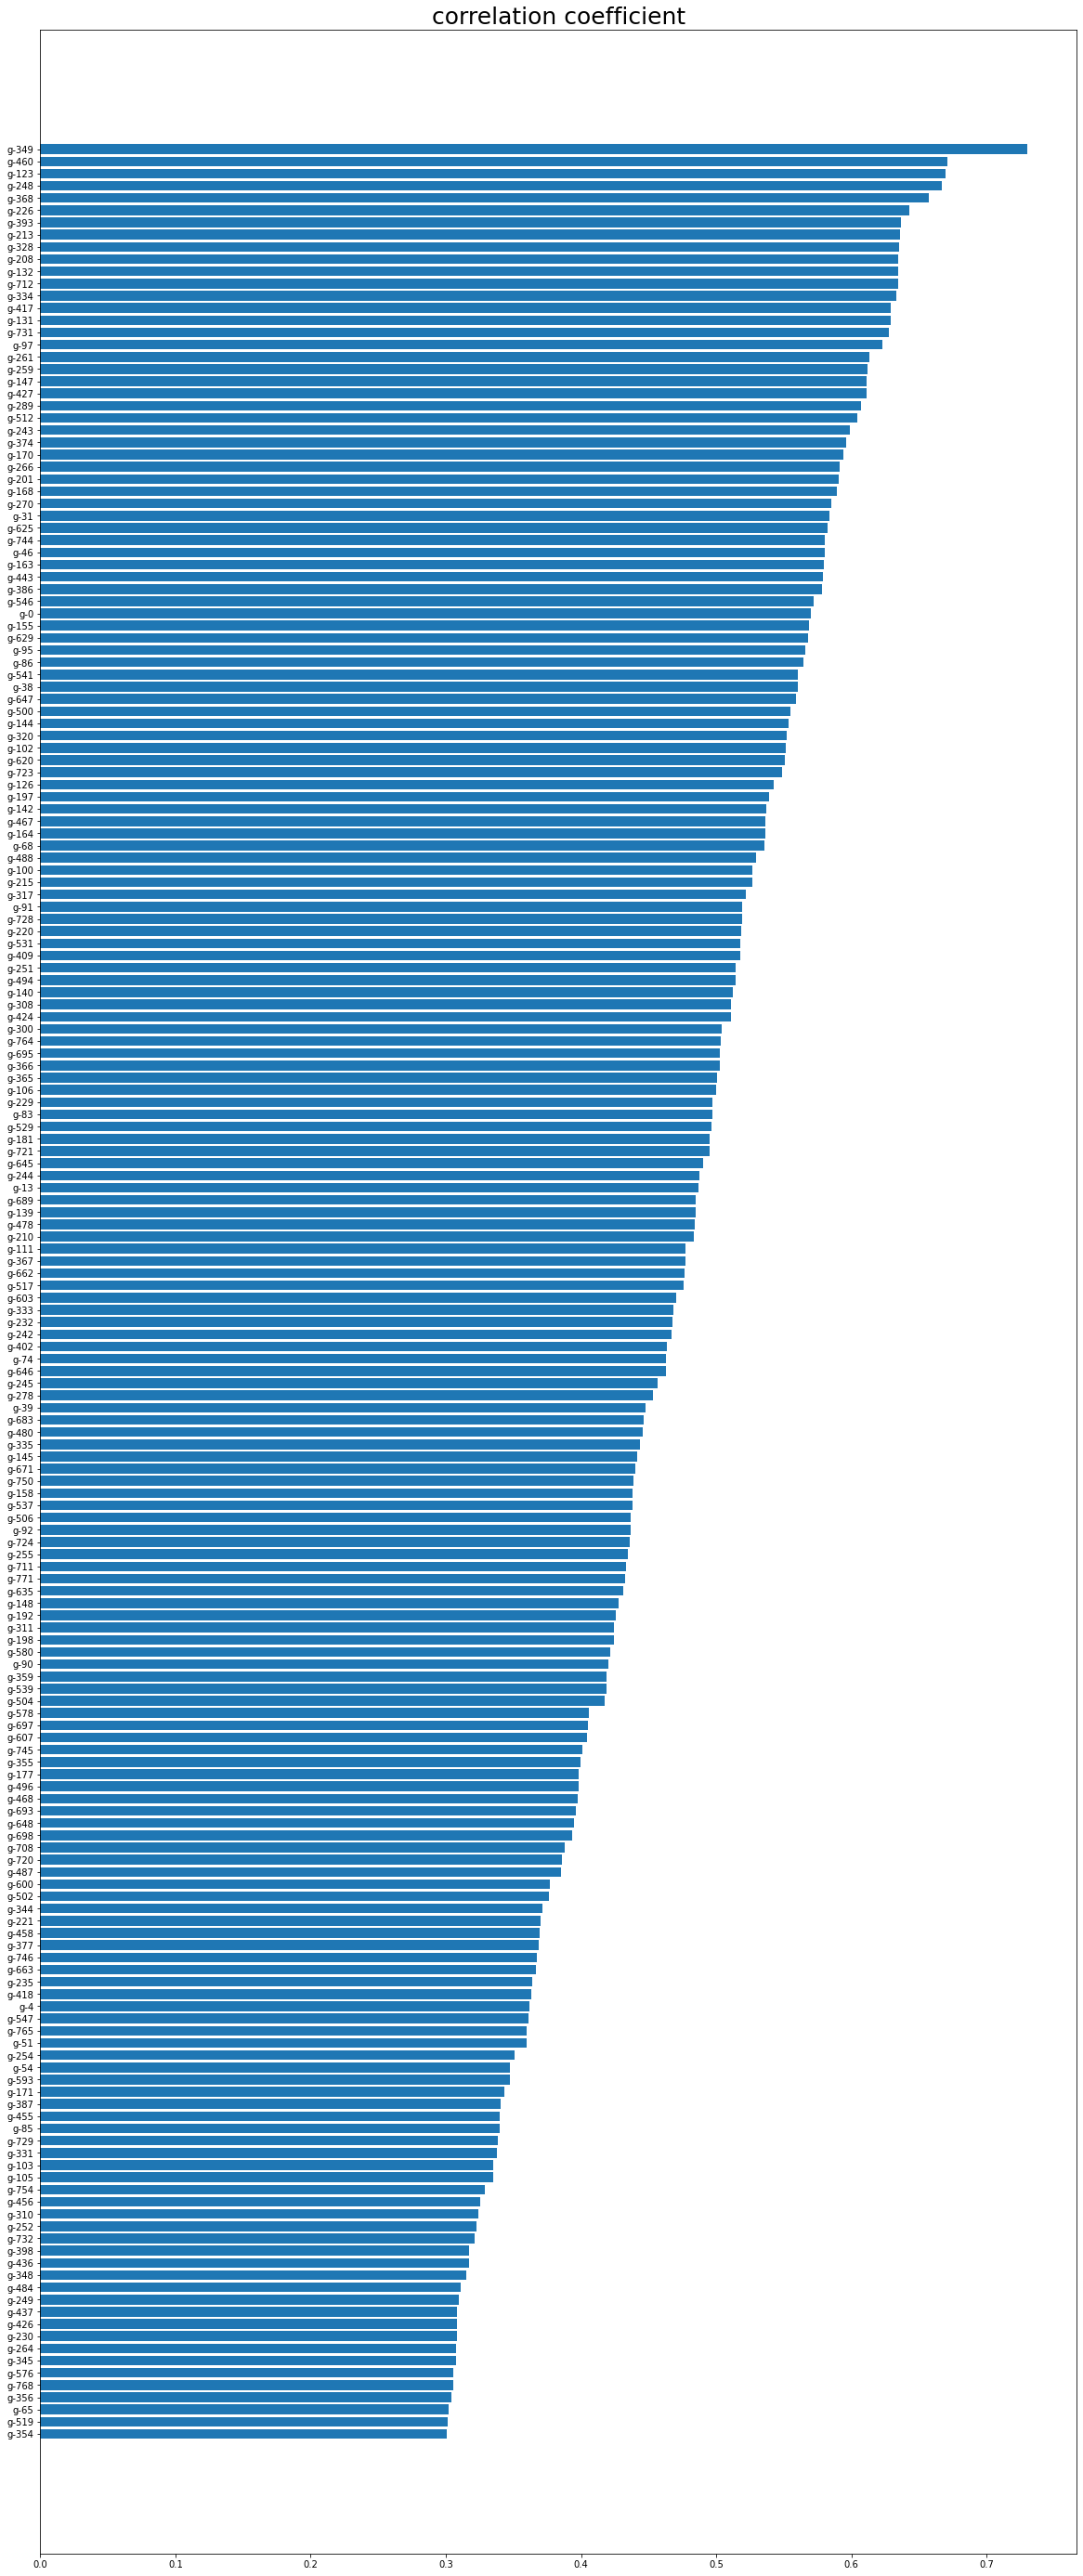

In [ ]:
# 棒グラフで相関関係を可視化（相関係数0.3より大きいもののみ表示）
corr = df_corr2_[df_corr2_ > 0.3]
y = corr.values
x = corr.index.values
plt.figure(figsize=(20, 50)) 
plt.barh(x, y)
plt.title("correlation coefficient", fontsize=25)
plt.show()

In [ ]:
# 相関が特に高い g-97 までを抽出(上位17個)し、説明変数に使用する
print("g-97:", df_corr2_["g-97"])
print("g-261:", df_corr2_["g-261"])
df_corr2_ = df_corr2_[df_corr2_ > 0.62]

g-97: 0.6229317653251613
g-261: 0.6131903975024628


目的変数(nfkb_inhibitor)との相関が高い(0.62以上）17個に説明変数を絞った。

In [ ]:
# 説明変数(X2)：目的変数との相関が高い17個 + cp_type + cp_time + cp_dose
# 目的変数(Y)：nfkb_inhibitor

# df_corr2_のindexをリスト型で取得。その他の説明変数（cp_type_ctl_vehicle、cp_type_trt_cp、cp_time_24、cp_time_48、cp_time_72、cp_dose_D1、cp_dose_D2）もリストに追加する
X2_list = df_corr2_.index.values.tolist()
X2_list += ["cp_type_ctl_vehicle", "cp_type_trt_cp", "cp_time_24", "cp_time_48", "cp_time_72", "cp_dose_D1", "cp_dose_D2"]

# datasetのうち、列名が X2_list に含まれるものを取得。detaset2とする
dataset2 = dataset[X2_list]
print(dataset2.shape)
dataset2.head()

(23814, 24)


g-97   g-731   g-131   g-417   g-334   g-712   g-132   g-208   g-328  \
0  0.4527 -0.5949 -0.7349 -0.5257 -0.2111 -0.2511  0.3116 -0.8059  0.2406   
1  0.4300 -1.2270 -0.0493 -0.3536  0.0415  0.6474  0.0806 -0.3027 -0.3950   
2  0.0955  0.4860 -0.3465  0.6638  1.0430 -0.1150 -0.6194 -0.7341  0.4777   
3 -1.7220  0.9512  3.0850  1.8810  0.2451 -1.0620  0.0196  0.7044  0.3398   
4 -0.2334  0.9106  2.0390  0.0333 -0.6595 -0.9680  0.4533  0.5398  0.2954   

    g-213   g-393   g-226   g-368   g-248   g-123   g-460   g-349  \
0  0.1093  0.4300 -0.6200  0.0323 -0.3072  0.0486 -1.4880 -0.3083   
1  0.1875  0.1015 -0.0678 -0.5125  1.0880  0.0804  0.2496 -0.2037   
2  0.0000 -0.0571  0.9388 -1.1920  1.0790  0.1807  0.9004  1.0100   
3  0.0000  0.1787 -0.2829  0.3278 -0.2261 -0.2583  0.9815  1.3710   
4 -0.6745 -1.1990  0.4805 -0.8983 -0.3918 -1.3950 -0.6745 -1.2180   

   cp_type_ctl_vehicle  cp_type_trt_cp  cp_time_24  cp_time_48  cp_time_72  \
0                    0               1           1           0           0   
1                    0               1           0           0           1   
2                    0               1           0           1           0   
3                    0               1           0           1           0   
4                    0               1           0           0           1   

   cp_dose_D1  cp_dose_D2  
0           1           0  
1           1           0  
2           1           0  
3           1           0  
4           0           1

In [ ]:
X2 = np.array(dataset2)
Y = np.array(train_scored2["nfkb_inhibitor"])

In [ ]:
# 形状を確認
print("Y=", Y.shape, ", X2=", X2.shape)

Y= (23814,) , X2= (23814, 24)


In [ ]:
# データの分割(X2とYを使う)
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (11668,) , X_train= (11668, 24)
Y_valid= (5001,) , X_valid= (5001, 24)
Y_test= (7145,) , X_test= (7145, 24)


input_shapeを879個から24個に削減することができた。

#### ５．モデルの複雑化  

inputを減らして層を1層増やす。Dropout層はカットする。


In [ ]:
# モデルの初期化
model4 = keras.Sequential()

# 入力層
model4.add(Dense(64, activation="relu", input_shape=(24,)))
# 隠れ層
model4.add(Dense(32, activation="relu"))
# 隠れ層
model4.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l1(0.01)))
# 出力層
model4.add(Dense(1, activation="sigmoid"))

# モデルの構築
model4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1600      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model4.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1)], validation_data=(X_valid, Y_valid))

Epoch 1/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.5143 - accuracy: 0.9830 - val_loss: 0.1685 - val_accuracy: 0.9900
Epoch 2/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.1098 - accuracy: 0.9901 - val_loss: 0.0926 - val_accuracy: 0.9878
Epoch 3/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.9908 - val_loss: 0.0681 - val_accuracy: 0.9904
Epoch 4/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.0587 - accuracy: 0.9907 - val_loss: 0.0596 - val_accuracy: 0.9906
Epoch 5/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9913 - val_loss: 0.0583 - val_accuracy: 0.9904
Epoch 6/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.0494 - accuracy: 0.9918 - val_loss: 0.0545 - val_accuracy: 0.9912
Epoch 7/1000
365/365 [==============================] - 1s 2ms/step - loss: 0.0487 - accuracy: 0.9911 - val_loss: 0.0532 - val_accuracy:

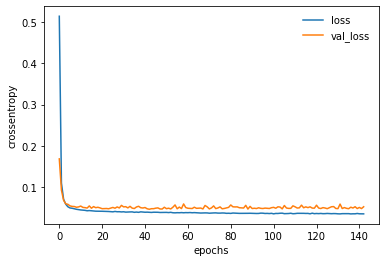

In [ ]:
# グラフ表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

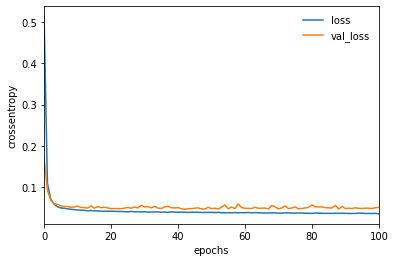

In [ ]:
# 拡大して表示
plt.plot(log.history["loss"], label="loss")
plt.plot(log.history["val_loss"], label="val_loss")
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.xlim(0, 100)
plt.show()

### ≪結果≫  
lossが右肩下がりに下がっており、過学習も見られない。良好な結果を得た。

## 【テストデータによる評価】

In [ ]:
# 予測
Y_pred = model4.predict(X_test)

# 予測結果の確率が0.5以下なら0、それより大きければ1となる計算で求める
Y_pred_cls = (Y_pred > 0.5).astype("int32")

In [ ]:
print("Y_pred_cls:", Y_pred_cls.shape)
print("Y_test:", Y_test.shape)

Y_pred_cls: (7145, 1)
Y_test: (7145,)


In [ ]:
# 形状を目的変数に合わせる
Y_pred_ = Y_pred_cls.reshape(-1)
print("Y_pred_:", Y_pred_.shape)

Y_pred_: (7145,)


In [ ]:
# モデルの評価
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred_))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6888
           1       0.95      0.84      0.89       257

    accuracy                           0.99      7145
   macro avg       0.97      0.92      0.94      7145
weighted avg       0.99      0.99      0.99      7145



#### ≪結果≫  
- 汎化性能としてf1値99%という高いスコアで予測することができた。  
- 1点、懸念事項として次の点が挙げられた。  
目的変数(nfkb_inhibitor)と相関係数の高い説明変数を解析した際（【モデルの検討】４．参照）、テストデータとして用いるデータセットも含めて解析してしまった。  
テストデータを含めなければ抽出される説明変数が異なる可能性があり、テストデータを含めたためにこのような高い精度になったのではないかという懸念が浮上した。  
- 以下、改めてテストデータとして用いるデータセットは除外してデータの前処理（相関係数の解析）をし直した。


#### ≪以下は確認作業≫

In [ ]:
# inputを減らすために、目的変数（nfkb_inhibitor）に相関のある説明変数を抽出する
# 相関の解析は、テストデータ(X_test, Y_test）は含めずに行うべきなので、
# 一旦、X_train, X_valid, Y_train, Y_validをDataFrameに戻す

# X_train, X_validのカラム名
nd_X_columns = dataset.iloc[:, 1:].columns.values
# X_train, X_validをDataFrame型へ変換
X_train_ = pd.DataFrame(data = X_train, columns = nd_X_columns)
X_valid_ = pd.DataFrame(data = X_valid, columns = nd_X_columns)
# X_train_のDataFrame下に、X_valid_のDataFrameを結合
X_ = X_train_.append(X_valid_, ignore_index=True)

In [ ]:
# 確認
print(X_.shape)
X_.head()

(16669, 879)


g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7     g-8  \
0  0.3813 -0.5708  0.8578 -0.6485  0.0037 -0.9208 -1.1740 -0.1013  1.9310   
1 -0.8807 -0.1270 -0.5026  0.1923 -1.3480  1.1120  1.2500 -0.2818  0.2086   
2  0.0695 -1.6650 -0.5419  0.0516  0.7049  0.2979  1.1190 -0.3733  0.5493   
3  0.4294 -0.2222  0.3682 -1.0180  0.2988  1.8640  0.4591  0.6418 -0.5665   
4  0.0902 -0.5834  0.2686 -0.1990  0.2471  1.3270  0.6100  0.2312 -0.1127   

      g-9    g-10    g-11    g-12    g-13    g-14    g-15    g-16    g-17  \
0 -0.8327  0.0530  0.1054 -0.5070  0.7556  0.5712 -0.9736  0.3426  0.9744   
1  1.5380  0.0508 -0.9597  2.1270  0.3868 -0.7872 -0.4506  0.9271  0.0988   
2  0.9915 -1.0200  0.3730 -0.5271 -0.1018 -0.6490  0.1734  0.3406  0.5130   
3 -0.6336 -0.2798 -0.9405 -0.2233 -0.2910 -0.8253 -1.0880 -0.2761  0.8895   
4  0.6225 -0.1738  2.5290  1.4470 -0.7045  0.0786  0.6563  0.2920 -0.5843   

     g-18    g-19    g-20    g-21    g-22    g-23    g-24    g-25    g-26  \
0 -0.6798 -0.1810  0.2162 -0.8015 -0.6425 -0.9882 -0.7923  0.1758  0.2899   
1  0.4516  0.0640  1.2650 -1.5220 -0.6119  1.0430 -0.2668  0.6099  1.1780   
2 -0.3595  0.1736  0.2171  1.3820 -0.0984  0.2983 -1.6800 -1.3490 -0.1403   
3  0.6698 -0.4529  0.6572  2.0890  1.3950 -1.2250 -0.0024 -0.2826  0.5106   
4  0.0000  0.5232 -0.0819  0.1170  0.2155 -0.2711  0.3227 -0.3204  0.3385   

     g-27    g-28    g-29    g-30    g-31    g-32    g-33    g-34    g-35  \
0 -0.3078 -0.0469 -0.5564 -1.6140  0.0408 -0.7347 -1.5250 -0.1381  0.3138   
1 -0.5613  0.4735  0.4997 -0.2391  0.2287  0.1053  0.2183 -0.5557 -0.3315   
2 -2.3460 -0.0481  0.9359 -1.1040  0.9645  0.3594 -0.3314 -1.4350  0.5949   
3 -0.2962  0.6707 -0.2628  0.3716 -0.5106 -0.2675  1.0040 -0.5906  1.2080   
4  0.1170 -0.1848 -0.6893  0.5380 -0.7259  0.4128  0.7320  0.0100 -0.1452   

     g-36    g-37    g-38    g-39    g-40    g-41    g-42    g-43    g-44  \
0 -2.0580 -0.9856  1.0610 -0.1851  0.4627 -0.7171 -0.8684  0.0584  0.1935   
1  0.5085  0.8146 -0.8156 -0.6529  2.7010  1.8380 -1.5530 -0.5301  0.2236   
2 -0.5375  0.5547 -0.3144 -0.6273  1.2600 -0.0639  1.7330  0.5240 -0.1248   
3  0.1795  0.4854 -0.9753  0.4411 -1.0510 -0.8922 -0.2116  1.0450 -1.0300   
4 -0.4269  0.1723  1.8700  0.2652  0.0088  1.3610  0.4132 -0.0386 -0.5885   

     g-45    g-46    g-47    g-48    g-49    g-50    g-51    g-52    g-53  \
0 -0.5597  0.8519 -0.2921 -0.0616  0.2574 -1.8020 -0.7212 -2.0530  0.7870   
1 -0.3070  0.0000 -0.0246  0.1648 -0.3772  0.1059  0.8833  0.1827  1.8820   
2 -1.0250  0.0649 -0.5059  0.3950 -1.2370  0.6222  0.1970 -0.4053  1.0770   
3  0.2470  0.1470 -1.1450 -1.0610  0.5418  0.3415 -0.0101  0.9495  1.7020   
4 -0.0132 -0.1120 -0.4606 -0.3484  0.4831  0.2889  0.1044  0.1847 -0.1511   

     g-54    g-55    g-56    g-57    g-58    g-59    g-60    g-61    g-62  \
0  1.0470 -0.4507  0.4420 -0.2308 -1.7740 -1.9880 -1.2320  0.2169  0.8414   
1 -0.2277  0.4660 -0.6768  0.5803  0.5296  0.0139  0.9796 -0.2242 -0.3882   
2 -0.0550  1.2860  0.4732 -0.2296 -0.5059  1.2690 -1.3250  0.3838 -0.2137   
3 -0.8716 -0.1752  0.7814 -0.6270  0.0636  0.2537 -0.3900  0.4937  1.0320   
4  0.9434  0.2039 -0.3157  0.1353 -0.6675  0.0108 -0.0017  0.3212 -0.9559   

     g-63    g-64    g-65    g-66    g-67    g-68    g-69    g-70    g-71  \
0 -0.8660 -0.6911  1.9740 -0.1864  0.1278 -0.6908  0.8133 -0.4363 -1.5700   
1 -0.5642  0.3295 -0.2861 -0.0115 -0.1489 -0.4888  3.0550  0.3994 -0.2280   
2  0.3960  0.7950 -0.3711  0.0474 -0.4704 -0.7549 -0.9696  0.1132  0.3768   
3  0.5910  0.6352  1.0460 -0.1459  1.0770 -0.1801 -1.5000  2.6590 -1.9450   
4  0.5252  0.1693 -0.7042  0.5764  0.2360  0.5605  0.9941 -0.1269  0.5975   

     g-72    g-73    g-74    g-75    g-76    g-77    g-78    g-79    g-80  \
0 -1.5200 -0.1191  1.4460 -3.1460 -0.1352 -0.1745  0.0837 -0.4022  0.3965   
1  0.4417  0.2621  0.4245  0.4251  0.6650 -0.7648  0.0491  0.5314  0.4923   
2  3.1840 -1.6840  0.4991  0.5135  0.0000  0.2255  0.6661 -0.4660  1.73

In [ ]:
# Y_train, Y_validをSeries型へ変換
Y_train_ = pd.Series(data = Y_train, name = "nfkb_inhibitor")
Y_valid_ = pd.Series(data = Y_valid, name = "nfkb_inhibitor")
# Y_train_のSeries下に、Y_valid_のSeriesを結合
Y_ = pd.concat([Y_train_, Y_valid_])

In [ ]:
# 確認
print(Y_.shape)
Y_.head()

(16669,)


0    0
1    0
2    0
3    0
4    0
Name: nfkb_inhibitor, dtype: int64

In [ ]:
# X_のDataFrameにSeries型のY_を挿入できなかったので
# Y_をもう一度numpy配列に戻した
np_Y_ = Y_.values

In [ ]:
# X_とY_の相関をとるために、X_のDataFrameにnp_Y_を挿入する
X_.insert(0, "nfkb_inhibitor", np_Y_)
print(X_.shape)
X_.head()

(16669, 880)


nfkb_inhibitor     g-0     g-1     g-2     g-3     g-4     g-5     g-6  \
0               0  0.3813 -0.5708  0.8578 -0.6485  0.0037 -0.9208 -1.1740   
1               0 -0.8807 -0.1270 -0.5026  0.1923 -1.3480  1.1120  1.2500   
2               0  0.0695 -1.6650 -0.5419  0.0516  0.7049  0.2979  1.1190   
3               0  0.4294 -0.2222  0.3682 -1.0180  0.2988  1.8640  0.4591   
4               0  0.0902 -0.5834  0.2686 -0.1990  0.2471  1.3270  0.6100   

      g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14    g-15  \
0 -0.1013  1.9310 -0.8327  0.0530  0.1054 -0.5070  0.7556  0.5712 -0.9736   
1 -0.2818  0.2086  1.5380  0.0508 -0.9597  2.1270  0.3868 -0.7872 -0.4506   
2 -0.3733  0.5493  0.9915 -1.0200  0.3730 -0.5271 -0.1018 -0.6490  0.1734   
3  0.6418 -0.5665 -0.6336 -0.2798 -0.9405 -0.2233 -0.2910 -0.8253 -1.0880   
4  0.2312 -0.1127  0.6225 -0.1738  2.5290  1.4470 -0.7045  0.0786  0.6563   

     g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23    g-24  \
0  0.3426  0.9744 -0.6798 -0.1810  0.2162 -0.8015 -0.6425 -0.9882 -0.7923   
1  0.9271  0.0988  0.4516  0.0640  1.2650 -1.5220 -0.6119  1.0430 -0.2668   
2  0.3406  0.5130 -0.3595  0.1736  0.2171  1.3820 -0.0984  0.2983 -1.6800   
3 -0.2761  0.8895  0.6698 -0.4529  0.6572  2.0890  1.3950 -1.2250 -0.0024   
4  0.2920 -0.5843  0.0000  0.5232 -0.0819  0.1170  0.2155 -0.2711  0.3227   

     g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32    g-33  \
0  0.1758  0.2899 -0.3078 -0.0469 -0.5564 -1.6140  0.0408 -0.7347 -1.5250   
1  0.6099  1.1780 -0.5613  0.4735  0.4997 -0.2391  0.2287  0.1053  0.2183   
2 -1.3490 -0.1403 -2.3460 -0.0481  0.9359 -1.1040  0.9645  0.3594 -0.3314   
3 -0.2826  0.5106 -0.2962  0.6707 -0.2628  0.3716 -0.5106 -0.2675  1.0040   
4 -0.3204  0.3385  0.1170 -0.1848 -0.6893  0.5380 -0.7259  0.4128  0.7320   

     g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41    g-42  \
0 -0.1381  0.3138 -2.0580 -0.9856  1.0610 -0.1851  0.4627 -0.7171 -0.8684   
1 -0.5557 -0.3315  0.5085  0.8146 -0.8156 -0.6529  2.7010  1.8380 -1.5530   
2 -1.4350  0.5949 -0.5375  0.5547 -0.3144 -0.6273  1.2600 -0.0639  1.7330   
3 -0.5906  1.2080  0.1795  0.4854 -0.9753  0.4411 -1.0510 -0.8922 -0.2116   
4  0.0100 -0.1452 -0.4269  0.1723  1.8700  0.2652  0.0088  1.3610  0.4132   

     g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50    g-51  \
0  0.0584  0.1935 -0.5597  0.8519 -0.2921 -0.0616  0.2574 -1.8020 -0.7212   
1 -0.5301  0.2236 -0.3070  0.0000 -0.0246  0.1648 -0.3772  0.1059  0.8833   
2  0.5240 -0.1248 -1.0250  0.0649 -0.5059  0.3950 -1.2370  0.6222  0.1970   
3  1.0450 -1.0300  0.2470  0.1470 -1.1450 -1.0610  0.5418  0.3415 -0.0101   
4 -0.0386 -0.5885 -0.0132 -0.1120 -0.4606 -0.3484  0.4831  0.2889  0.1044   

     g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59    g-60  \
0 -2.0530  0.7870  1.0470 -0.4507  0.4420 -0.2308 -1.7740 -1.9880 -1.2320   
1  0.1827  1.8820 -0.2277  0.4660 -0.6768  0.5803  0.5296  0.0139  0.9796   
2 -0.4053  1.0770 -0.0550  1.2860  0.4732 -0.2296 -0.5059  1.2690 -1.3250   
3  0.9495  1.7020 -0.8716 -0.1752  0.7814 -0.6270  0.0636  0.2537 -0.3900   
4  0.1847 -0.1511  0.9434  0.2039 -0.3157  0.1353 -0.6675  0.0108 -0.0017   

     g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68    g-69  \
0  0.2169  0.8414 -0.8660 -0.6911  1.9740 -0.1864  0.1278 -0.6908  0.8133   
1 -0.2242 -0.3882 -0.5642  0.3295 -0.2861 -0.0115 -0.1489 -0.4888  3.0550   
2  0.3838 -0.2137  0.3960  0.7950 -0.3711  0.0474 -0.4704 -0.7549 -0.9696   
3  0.4937  1.0320  0.5910  0.6352  1.0460 -0.1459  1.0770 -0.1801 -1.5000   
4  0.3212 -0.9559  0.5252  0.1693 -0.7042  0.5764  0.2360  0.5605  0.9941   

     g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77    g-78  \
0 -0.4363 -1.5700 -1.5200 -0.1191  1.4460 -3.1460 -0.1352 -0.1745  0.0837   
1  0.3994 -0.2280  0.4417  0.2621  0.4245  0.4251  0.6650 -0.7648  0.0491   
2  0.1132  0.3768  3.1840 -1.6840  0.4991  0.5135  0.0000  0.2255  0

In [ ]:
# 目的変数（nfkb_inhibitor）に相関のある説明変数を抽出する
# 説明変数（g-0～g-771、c-0～c-99）と目的変数との相関関係を把握
nfkb_corr = X_.iloc[:, :873].corr()
nfkb_corr.head()

nfkb_inhibitor       g-0       g-1       g-2       g-3  \
nfkb_inhibitor        1.000000  0.569066  0.073129  0.156887  0.158287   
g-0                   0.569066  1.000000  0.087410  0.172304  0.013856   
g-1                   0.073129  0.087410  1.000000 -0.053969 -0.026204   
g-2                   0.156887  0.172304 -0.053969  1.000000  0.047676   
g-3                   0.158287  0.013856 -0.026204  0.047676  1.000000   

                     g-4       g-5       g-6       g-7       g-8       g-9  \
nfkb_inhibitor  0.354589 -0.151961  0.120371 -0.479456 -0.547338 -0.402073   
g-0             0.395340 -0.160414  0.237537 -0.367647 -0.598054 -0.420763   
g-1             0.196934 -0.153063 -0.120125  0.141836 -0.010465 -0.051992   
g-2             0.014605  0.026338  0.021453 -0.143234 -0.125617 -0.083914   
g-3            -0.033835  0.042461 -0.045425 -0.188351 -0.077692 -0.019803   

                    g-10      g-11      g-12      g-13      g-14      g-15  \
nfkb_inhibitor -0.550125  0.291464 -0.254307  0.490777 -0.368089 -0.107655   
g-0            -0.545032  0.217348 -0.195272  0.471591 -0.332876 -0.201399   
g-1            -0.012951  0.157916  0.042031 -0.009721  0.006516 -0.075510   
g-2            -0.104890  0.007467 -0.066555  0.080087 -0.076667 -0.061943   
g-3            -0.074817  0.188305  0.023452  0.203621  0.124922 -0.047911   

                    g-16      g-17      g-18      g-19      g-20      g-21  \
nfkb_inhibitor -0.500569 -0.466725 -0.022323 -0.081463 -0.394271 -0.123266   
g-0            -0.508726 -0.426378 -0.016776 -0.073166 -0.476882  0.058729   
g-1            -0.069030  0.000282 -0.020859 -0.033775 -0.137833  0.204225   
g-2            -0.136608 -0.086082  0.057835  0.030955 -0.054979 -0.128946   
g-3             0.033303 -0.075316  0.235247  0.118829  0.017510 -0.169605   

                    g-22      g-23      g-24      g-25      g-26      g-27  \
nfkb_inhibitor -0.172396 -0.156018 -0.376600 -0.229933 -0.400209  0.133472   
g-0             0.017552 -0.075668 -0.330326 -0.214358 -0.410401  0.143616   
g-1            -0.060705  0.093300 -0.005015 -0.024750 -0.019903  0.014339   
g-2            -0.006397 -0.036609 -0.124326 -0.058107 -0.122377  0.033043   
g-3             0.203163 -0.052808 -0.118389  0.181502  0.112391  0.002075   

                    g-28      g-29      g-30      g-31      g-32      g-33  \
nfkb_inhibitor -0.534338 -0.386596 -0.536846  0.581790 -0.122327 -0.039027   
g-0            -0.465247 -0.301940 -0.526208  0.555026 -0.123232 -0.150324   
g-1            -0.100529 -0.092107 -0.057619 -0.050440  0.196558 -0.095626   
g-2            -0.122721 -0.014473 -0.149250  0.174571 -0.100000 -0.031760   
g-3            -0.025847 -0.136436 -0.048309  0.102817 -0.093521 -0.093463   

                    g-34      g-35      g-36      g-37      g-38      g-39  \
nfkb_inhibitor -0.083023  0.171649 -0.234901 -0.557664  0.555588  0.439003   
g-0            -0.122585  0.329301 -0.139711 -0.586621  0.592624  0.444906   
g-1             0.047651  0.047670 -0.085862 -0.013843 -0.042185  0.050485   
g-2            -0.013768 -0.003285 -0.021003 -0.159549  0.173216  0.140442   
g-3             0.188958 -0.079242 -0.326835 -0.232368  0.087089  0.049569   

                    g-40      g-41      g-42      g-43      g-44      g-45  \
nfkb_inhibitor -0.419059 -0.598352 -0.202995 -0.035293 -0.013513 -0.121193   
g-0            -0.422432 -0.492403 -0.205018  0.032760 -0.021916 -0.113654   
g-1            -0.000371 -0.113010  0.134590  0.154543 -0.096142  0.037129   
g-2            -0.079341 -0.102303 -0.129200 -0.085836  0.028446 -0.035668   
g-3             0.124928 -0.042562 -0.004046 -0.174210 -0.004417  0.063345   

                    g-46      g-47      g-48      g-49      g-50      g-51  \
nfkb_inhibitor  0.575081  0.022015  0.205464  0.287774 -0.533666  0.353890   
g-0             0.522703  0.037940  0.244982  0.314094 -0.550317  0.305012   
g-1             0.096681 -0.011121  0.043168 -0.109983

In [ ]:
# 上の相関係数の表からnfkb_inhibitorの行のみ取得
nfkb_corr = nfkb_corr.iloc[0, 1:]
nfkb_corr.head()

g-0    0.569066
g-1    0.073129
g-2    0.156887
g-3    0.158287
g-4    0.354589
Name: nfkb_inhibitor, dtype: float64

In [ ]:
# 相関係数の大きい順にソート
nfkb_corr_ = nfkb_corr.sort_values()
nfkb_corr_

c-78    -0.754271
c-53    -0.741330
c-32    -0.741036
c-31    -0.736199
c-85    -0.727695
           ...   
g-368    0.656997
g-123    0.664165
g-248    0.665979
g-460    0.669393
g-349    0.728592
Name: nfkb_inhibitor, Length: 872, dtype: float64

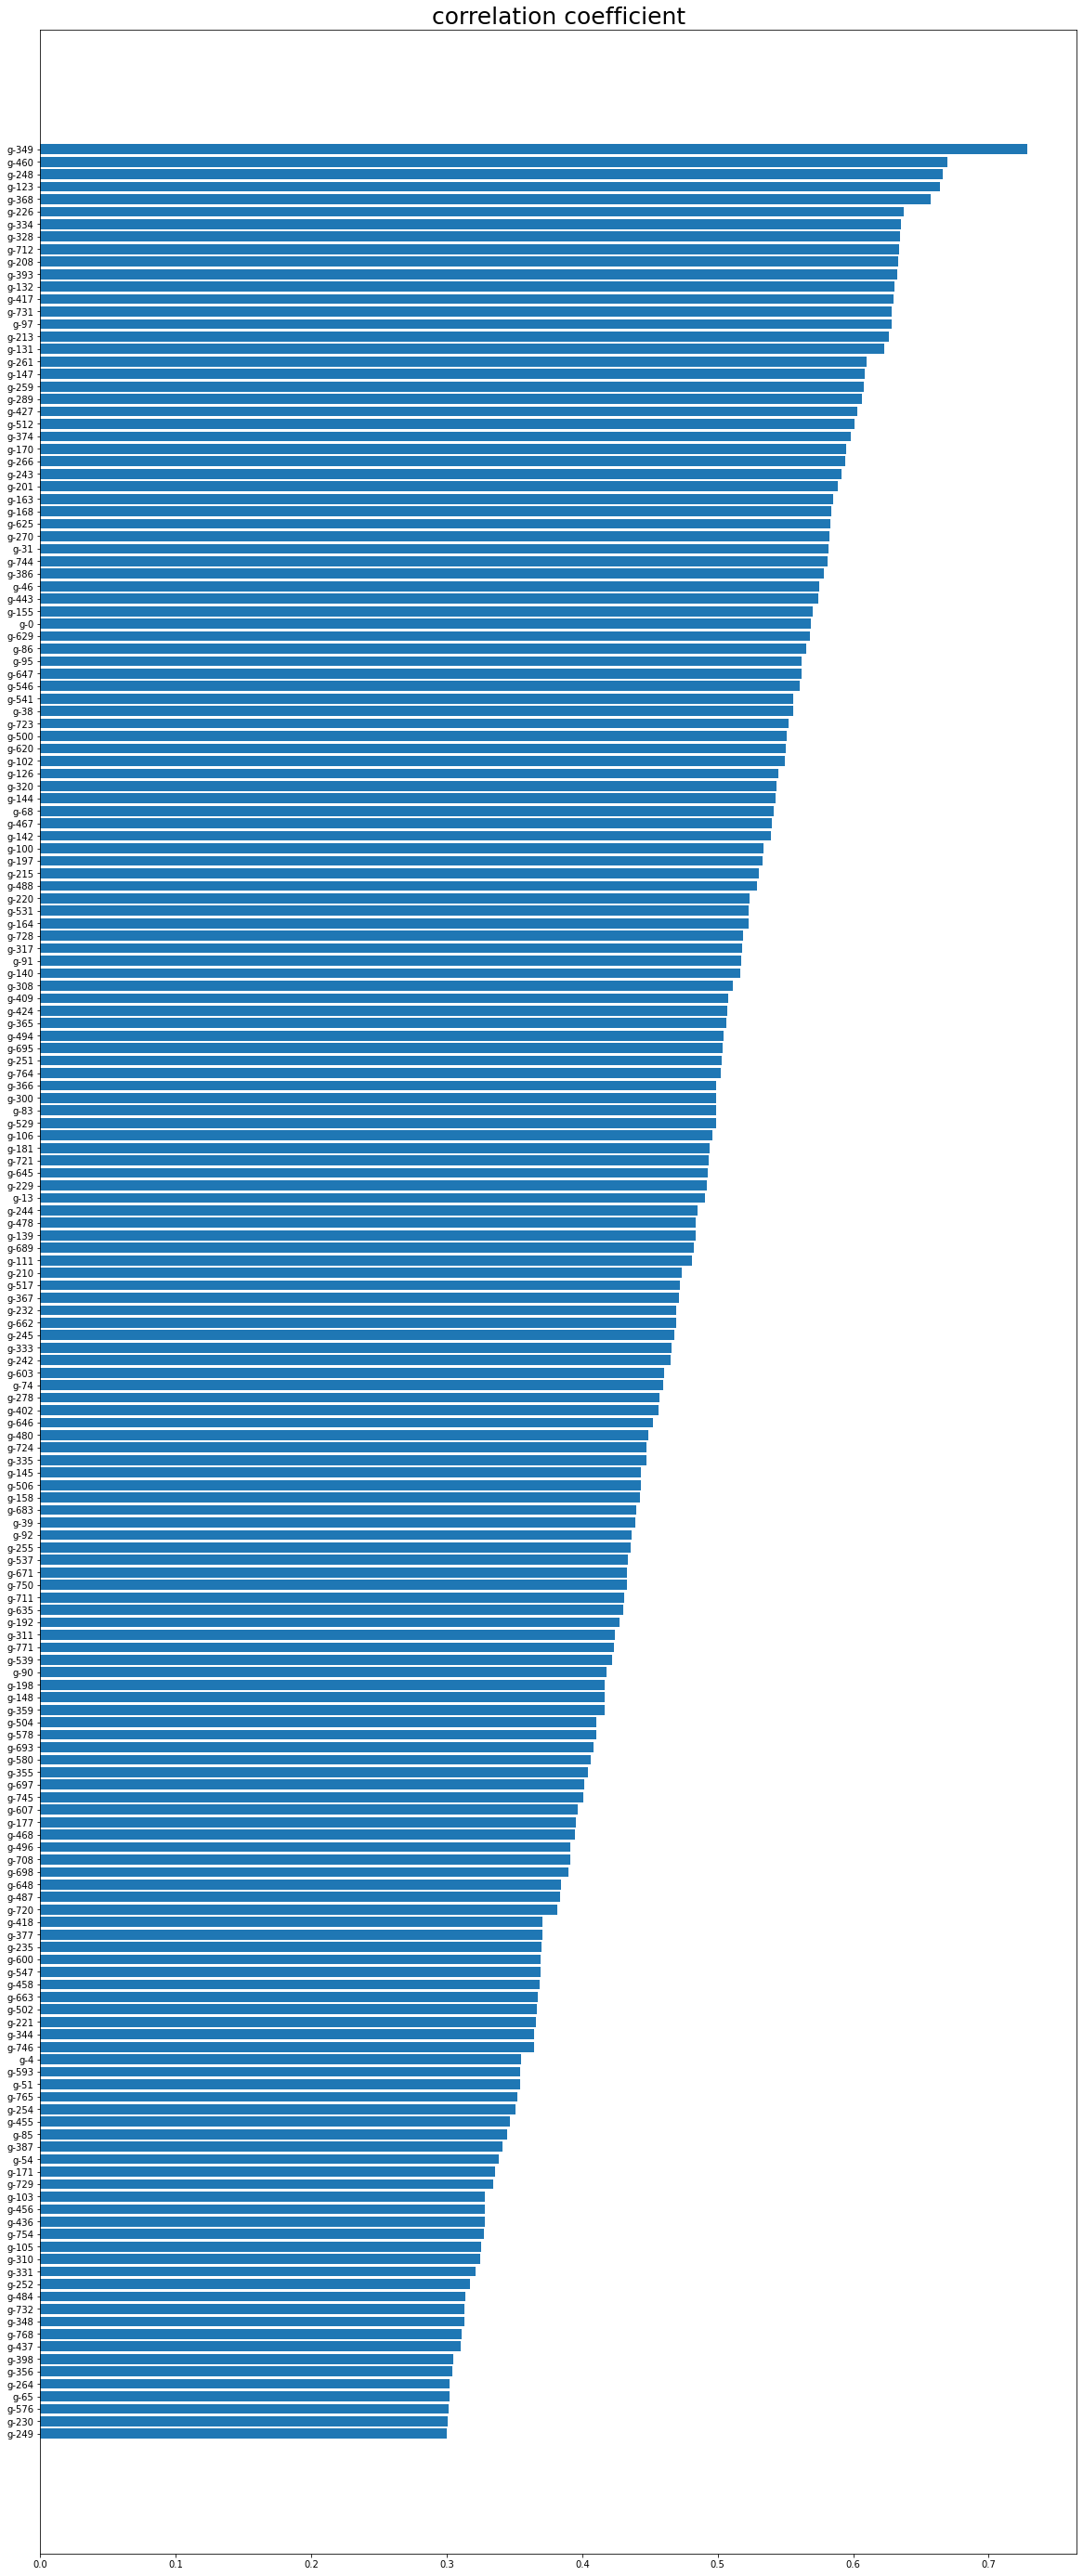

In [ ]:
# 棒グラフで相関関係を可視化（相関係数0.3より大きいもののみ表示）
corr = nfkb_corr_[nfkb_corr_ > 0.3]
y = corr.values
x = corr.index.values
plt.figure(figsize=(20, 50)) 
plt.barh(x, y)
plt.title("correlation coefficient", fontsize=25)
plt.show()

In [ ]:
# 相関が特に高い g-131 までを抽出(上位17個)し、説明変数に使用する
print("g-131:", nfkb_corr_["g-131"])
print("g-261:", nfkb_corr_["g-261"])

g-131: 0.6230242640543551
g-261: 0.6096738987552652


順序は微妙に異なるものの、【モデルの検討】４．と同じ説明変数が抽出された。  
以上より、【モデルの検討】５．のモデルの妥当性を確認した。


---

## 【まとめ】  
本ノートブックでは、与えられた細胞応答性の結果から、化合物がNFκb阻害作用を有するか否かを予測するモデルを作成した。  
872個あった説明変数のうち、NFκb阻害作用に相関の高い17個に絞ることで予測精度の高いモデルを作成することができた。  
本検討で得た知見を活かし、今後は207種類のMoAを予測するマルチラベルの分類モデルを作成したい。  